In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import pathlib
from functools import partial
import sys, glob
import numpy as np

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../deep-learning-base/training')
sys.path.append('../partially_inverted_reps')

import plot_helper as plt_hp
import output as out
from training import LitProgressBar, NicerModelCheckpointing
import training.finetuning as ft
import architectures as arch
from architectures.callbacks import LightningWrapper, LinearEvalWrapper
from attack.callbacks import AdvCallback
from datasets.data_modules import DATA_MODULES
import datasets.dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, SERVER_PROJECT_PATH

In [8]:
CHECKPOINT_PATHS = {
    'resnet50': {
        'nonrob': '',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'},
    'resnet50_ff8': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff8.pt'},
    'resnet50_ff16': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff16.pt'},
    'resnet50_ff32': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff32.pt'},
    'resnet50_ff64': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff64.pt'},
    'resnet50_ff128': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff128.pt'},
    'resnet50_ff256': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff256.pt'},
    'resnet50_ff512': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff512.pt'},
    'resnet50_ff1024': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff1024.pt'},
    'wide_resnet50_2': {
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/wideresnet-50-2-l2-eps3.ckpt'},
    'wide_resnet50_4': {
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/wideresnet-50-4-l2-eps3.ckpt'}
}

In [9]:
SEED = 2
NUM_NODES = 1
DEVICES = 1
BASE_DIR = f"{pathlib.Path('.').parent.resolve()}/checkpoints"

FINETUNE_MODE = 'random'
FINETUNE_BS = 256
EVAL_BATCH_SIZE = 100

In [10]:
def save_predictions(model_path, out):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    torch.save({'pred': out[0].detach().cpu(), 'gt': out[2].detach().cpu()}, preds_path)

def load_predictions(model_path):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    if os.path.exists(preds_path):
        return torch.load(preds_path)

def accuracy(gt, pred):
    pred = torch.argmax(pred, 1)
    return torch.sum(gt == pred) / len(gt)


def get_test_acc(model, source_dataset, finetuning_dataset, checkpoint_path, model_path, seed, fraction):
    state_dict = torch.load(model_path)
    dm = DATA_MODULES[finetuning_dataset](
        data_dir=DATA_PATH_IMAGENET if 'imagenet' in finetuning_dataset else DATA_PATH,
        transform_train=dsmd.TRAIN_TRANSFORMS_TRANSFER_DEFAULT(224),
        transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
        batch_size=EVAL_BATCH_SIZE)
    dm.init_remaining_attrs(source_dataset)

    ## assign mean and std from source dataset
    m1 = arch.create_model(model, source_dataset, pretrained=True,
                           checkpoint_path=checkpoint_path, seed=SEED, 
                           num_classes=dsmd.DATASET_PARAMS[source_dataset]['num_classes'],
                           callback=partial(LightningWrapper, 
                                            dataset_name=source_dataset,
                                            inference_kwargs={'with_latent': True}),
                           loading_function_kwargs={'strict': False}) # some final layers are strange
    new_layer = ft.setup_model_for_finetuning(
        m1.model, 
        dsmd.DATASET_PARAMS[finetuning_dataset]['num_classes'],
        FINETUNE_MODE, fraction, seed)
    print (new_layer.__dict__)
    linear_layer = list(m1.model.named_modules())[-1][1]
    linear_layer.load_state_dict({k.split('.')[-1]:v \
                                  for k,v in state_dict['state_dict'].items()}, strict=True)
    if hasattr(new_layer, 'neuron_indices') and 'neuron_indices' in state_dict:
        assert torch.all(new_layer.neuron_indices == state_dict['neuron_indices'])
    pl_utils.seed.seed_everything(seed, workers=True)

    trainer = Trainer(accelerator='gpu', 
                      devices=DEVICES,
                      num_nodes=NUM_NODES,
                      log_every_n_steps=1,
                      auto_select_gpus=True, 
                      deterministic=True,
                      check_val_every_n_epoch=1,
                      num_sanity_val_steps=0,
                      callbacks=[
                        LitProgressBar(['loss', 
                                        'running_test_acc'])])

    out = trainer.predict(m1, dataloaders=[dm.test_dataloader()])
    save_predictions(model_path, out)
    return accuracy(out[2], out[0])

In [18]:
def results(models_to_compare, source_dataset, ft_ds, append, FRACTIONS_OR_NUMBERS):
    plt_str = '== Finetuning results ==\n\n'
    model_to_fracwise_accs = {}
    for idx, model in enumerate(models_to_compare):
        plt_str += f'=== {model} - {append} - {ft_ds} ===\n\n'
        frac_wise_test_accs = {}
        if FRACTIONS_OR_NUMBERS[idx] is None:
            PARTIAL_FRACTIONS = sorted(
                list(set(
                    [float(x.split('/frac-')[1].split('-')[0]) for x in \
                            glob.glob(f'./checkpoints/{model}-base-'
                                      f'{source_dataset}-ft-{ft_ds}/'
                                      f'*-bs-256-{append}/*-topk=1.ckpt') \
                     if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                        'layer' not in x.split('/')[-1] and \
                        'pool' not in x.split('/')[-1] and \
                        'full-feature' not in x.split('/')[-1]]
                )))
        else:
            PARTIAL_FRACTIONS = FRACTIONS_OR_NUMBERS[idx]

        for frac in PARTIAL_FRACTIONS:
            if isinstance(frac, int):
                actual_fraction = frac / PARTIAL_FRACTIONS[-1]
            else:
                actual_fraction = frac
            model_paths = [x for x in glob.glob(f'{BASE_DIR}/{model}-base-{source_dataset}-ft-{ft_ds}/'
                                           f'frac-{actual_fraction:.5f}-mode-{FINETUNE_MODE}-seed-*-'
                                           f'ftmode-linear-lr-*-bs*-{append}/'
                                           '*-topk=1.ckpt') \
                           if 'layer' not in x.split('/')[-1] and \
                              'pool' not in x.split('/')[-1] and \
                              'full-feature' not in x.split('/')[-1]]
            for path in model_paths:
                pickled_preds = load_predictions(path)
                if pickled_preds is None:
                    acc = get_test_acc(model, source_dataset, ft_ds, 
                                       CHECKPOINT_PATHS[model][append], path, 
                                       int(path.split('-seed-')[1].split('-')[0]), actual_fraction).item()
                else:
                    acc = accuracy(pickled_preds['gt'], pickled_preds['pred'])
                
                if actual_fraction in frac_wise_test_accs:
                    frac_wise_test_accs[actual_fraction].append(acc)
                else:
                    frac_wise_test_accs[actual_fraction] = [acc]
        model_to_fracwise_accs[model] = frac_wise_test_accs

    x_vals = [sorted(list(model_to_fracwise_accs[model].keys())) for model in models_to_compare]
    plt_str += '{}\n\n'.format(plt_hp.get_wiki_link(plt_hp.line_plot(
        [[np.nanmean(model_to_fracwise_accs[model][f]) for f in sorted(model_to_fracwise_accs[model].keys())] \
             for model in models_to_compare], 
        'Fraction of neurons', 'Transfer Accuracy', ft_ds, 
        subfolder=source_dataset, 
        filename=f'{"-".join(models_to_compare)}_{ft_ds}_bs_{FINETUNE_BS}_{append}', 
        extension='png', x_vals=x_vals, 
        legend_vals=[m for m in models_to_compare], 
        vertical_line=None, colors=plt_hp.COLORS, 
        linestyles=['-'] * len(models_to_compare), 
        y_lims=(0.,1.), root_dir='.', paper_friendly_plots=True, 
        plot_inside=False, legend_location='best', savefig=True, 
        figsize=(10,6), marker=[True] * len(models_to_compare), 
        results_subfolder_name='width_comparison', grid_spacing=None, 
        y_err=[[np.nanstd(model_to_fracwise_accs[model][f]) \
                for f in sorted(model_to_fracwise_accs[model].keys())] for model in models_to_compare], 
        legend_ncol=3), SERVER_PROJECT_PATH, size=700))

    with open(f'./results/width_comparison/{source_dataset}/wiki_results-{model}.txt', 'w') as fp:
        fp.write(plt_str)
    out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, 'width_comparison', source_dataset)], 
        'results', SERVER_PROJECT_PATH, '.png')

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002]), 'in_features': 4, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61]), 'in_features': 4, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 708, 342,   9]), 'in_features': 4, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([122, 739, 133,  11]), 'in_features': 4, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([874, 636, 761, 257]), 'in_features': 4, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([874, 636, 761, 257, 824, 970, 354, 432]), 'in_features': 8, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([122, 739, 133,  11, 853, 464, 457, 929]), 'in_features': 8, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 708, 342,   9, 647, 767, 633, 291]), 'in_features': 8, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18]), 'in_features': 8, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479]), 'in_features': 8, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=10, bias=True))]), 'neuron_indices': tensor([122, 739, 133,  11, 853, 464, 457, 929,  10,  30, 386, 789, 715, 332,
        834, 687]), 'in_features': 16, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=10, bias=True))]), 'neuron_indices': tensor([ 874,  636,  761,  257,  824,  970,  354,  432,  493,  373,  938,  758,
         981, 1014,  520,  589]), 'in_features': 16, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 708, 342,   9, 647, 767, 633, 291, 607, 306, 648, 514, 588, 660,
        257, 444]), 'in_features': 16, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=10, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479,  440,  300,  628,  847,
         779,  134,  439,  386]), 'in_features': 16, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=10, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18,  296,  258,  887,  422,
         719,  243,  912,  244]), 'in_features': 16, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=10, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18,  296,  258,  887,  422,
         719,  243,  912,  244,  391,  790,  863,   68,  533,  485,  442,   17,
         708,   10,  313,  855,  723,  735,  222,  138,  701,  111,  644,  542,
         621,  567,  879,  488,  494,  765,  474,  774,  984,  659,  441,  237]), 'in_features': 48, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=10, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479,  440,  300,  628,  847,
         779,  134,  439,  386,  719,  401,  370,  544,   36,  798,  773,  691,
         475,  382,  688,  432,  583,  187,  893,  306,  970,  817,  820,  985,
         335,  223,  765,  889,  268,  848,  214,  537,  395,  337,  503,  107]), 'in_features': 48, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 708, 342,   9, 647, 767, 633, 291, 607, 306, 648, 514, 588, 660,
        257, 444, 694, 492, 878, 770, 758,  89, 126, 561, 747, 223, 786, 658,
        261, 403, 156, 783, 631, 353, 491, 818, 699, 640, 310, 354, 253, 220,
        649, 552,  47, 136, 646, 570]), 'in_features': 48, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=10, bias=True))]), 'neuron_indices': tensor([ 874,  636,  761,  257,  824,  970,  354,  432,  493,  373,  938,  758,
         981, 1014,  520,  589,  631,  582,   26,  918,  152,  574,  439,  814,
         496,   66,  783,    8,  350,  634,  804,  659,   92,  896,  103,  795,
         857,  368,  340,  845,  509,  503,   52,  547,  198, 1016,  596,  800]), 'in_features': 48, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=10, bias=True))]), 'neuron_indices': tensor([122, 739, 133,  11, 853, 464, 457, 929,  10,  30, 386, 789, 715, 332,
        834, 687, 567, 151, 756, 681, 850, 125, 228, 641, 746, 158,  33, 541,
        199, 416, 869, 168, 262, 362, 858, 694, 650, 947, 105, 248, 736, 773,
        188, 513, 131, 915, 606, 521]), 'in_features': 48, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=10, bias=True))]), 'neuron_indices': tensor([ 874,  636,  761,  257,  824,  970,  354,  432,  493,  373,  938,  758,
         981, 1014,  520,  589,  631,  582,   26,  918,  152,  574,  439,  814,
         496,   66,  783,    8,  350,  634,  804,  659,   92,  896,  103,  795,
         857,  368,  340,  845,  509,  503,   52,  547,  198, 1016,  596,  800,
         273,  175,   43,  320,  701,  926,  458,  725,  973,  794,   45,  886,
         300,  453,  654,  775,  448,  823,  812,  168,  579,  944,  754,  714,
         559,  515,  311,  218,  5

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=10, bias=True))]), 'neuron_indices': tensor([ 122,  739,  133,   11,  853,  464,  457,  929,   10,   30,  386,  789,
         715,  332,  834,  687,  567,  151,  756,  681,  850,  125,  228,  641,
         746,  158,   33,  541,  199,  416,  869,  168,  262,  362,  858,  694,
         650,  947,  105,  248,  736,  773,  188,  513,  131,  915,  606,  521,
         538,  116,  623,  748,  306,  710,  500,  473,  922,  286,    7,   57,
        1023,  445,  671,  759,  977,  835,  601,  956,  433,  381,  294,  666,
         695,  984,  590,  220,   

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=10, bias=True))]), 'neuron_indices': tensor([  37,  708,  342,    9,  647,  767,  633,  291,  607,  306,  648,  514,
         588,  660,  257,  444,  694,  492,  878,  770,  758,   89,  126,  561,
         747,  223,  786,  658,  261,  403,  156,  783,  631,  353,  491,  818,
         699,  640,  310,  354,  253,  220,  649,  552,   47,  136,  646,  570,
         673,  113,  112,  322,   92,  888,  855,  776,   95,  941,  955,  247,
         626,  428,  789,   36,  277,  886,  987,  408,  348,    2, 1019,  129,
         868,  210,  896,  983,  1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=10, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18,  296,  258,  887,  422,
         719,  243,  912,  244,  391,  790,  863,   68,  533,  485,  442,   17,
         708,   10,  313,  855,  723,  735,  222,  138,  701,  111,  644,  542,
         621,  567,  879,  488,  494,  765,  474,  774,  984,  659,  441,  237,
         768,  479,  416,  538,  996,  898,  913,  300,  687,  514,  192,    5,
         525,  433,  435,  962,  369,  609, 1003,  919,  264,  236,  176,  393,
          28,   25,   33,   30, 10

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=10, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479,  440,  300,  628,  847,
         779,  134,  439,  386,  719,  401,  370,  544,   36,  798,  773,  691,
         475,  382,  688,  432,  583,  187,  893,  306,  970,  817,  820,  985,
         335,  223,  765,  889,  268,  848,  214,  537,  395,  337,  503,  107,
         816,  262,  500,  800,  170,  511,  292,  513,  591,  793,  263,  536,
         806,  502,  490,  264,  250,  669,  813,  454,  556,  651,  795,  828,
         504,  496,  521,  242,  9

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=10, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479,  440,  300,  628,  847,
         779,  134,  439,  386,  719,  401,  370,  544,   36,  798,  773,  691,
         475,  382,  688,  432,  583,  187,  893,  306,  970,  817,  820,  985,
         335,  223,  765,  889,  268,  848,  214,  537,  395,  337,  503,  107,
         816,  262,  500,  800,  170,  511,  292,  513,  591,  793,  263,  536,
         806,  502,  490,  264,  250,  669,  813,  454,  556,  651,  795,  828,
         504,  496,  521,  242,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=10, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18,  296,  258,  887,  422,
         719,  243,  912,  244,  391,  790,  863,   68,  533,  485,  442,   17,
         708,   10,  313,  855,  723,  735,  222,  138,  701,  111,  644,  542,
         621,  567,  879,  488,  494,  765,  474,  774,  984,  659,  441,  237,
         768,  479,  416,  538,  996,  898,  913,  300,  687,  514,  192,    5,
         525,  433,  435,  962,  369,  609, 1003,  919,  264,  236,  176,  393,
          28,   25,   33,   30, 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=10, bias=True))]), 'neuron_indices': tensor([  37,  708,  342,    9,  647,  767,  633,  291,  607,  306,  648,  514,
         588,  660,  257,  444,  694,  492,  878,  770,  758,   89,  126,  561,
         747,  223,  786,  658,  261,  403,  156,  783,  631,  353,  491,  818,
         699,  640,  310,  354,  253,  220,  649,  552,   47,  136,  646,  570,
         673,  113,  112,  322,   92,  888,  855,  776,   95,  941,  955,  247,
         626,  428,  789,   36,  277,  886,  987,  408,  348,    2, 1019,  129,
         868,  210,  896,  983,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=10, bias=True))]), 'neuron_indices': tensor([ 122,  739,  133,   11,  853,  464,  457,  929,   10,   30,  386,  789,
         715,  332,  834,  687,  567,  151,  756,  681,  850,  125,  228,  641,
         746,  158,   33,  541,  199,  416,  869,  168,  262,  362,  858,  694,
         650,  947,  105,  248,  736,  773,  188,  513,  131,  915,  606,  521,
         538,  116,  623,  748,  306,  710,  500,  473,  922,  286,    7,   57,
        1023,  445,  671,  759,  977,  835,  601,  956,  433,  381,  294,  666,
         695,  984,  590,  220,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=10, bias=True))]), 'neuron_indices': tensor([ 874,  636,  761,  257,  824,  970,  354,  432,  493,  373,  938,  758,
         981, 1014,  520,  589,  631,  582,   26,  918,  152,  574,  439,  814,
         496,   66,  783,    8,  350,  634,  804,  659,   92,  896,  103,  795,
         857,  368,  340,  845,  509,  503,   52,  547,  198, 1016,  596,  800,
         273,  175,   43,  320,  701,  926,  458,  725,  973,  794,   45,  886,
         300,  453,  654,  775,  448,  823,  812,  168,  579,  944,  754,  714,
         559,  515,  311,  218,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=300, out_features=10, bias=True))]), 'neuron_indices': tensor([  37,  708,  342,    9,  647,  767,  633,  291,  607,  306,  648,  514,
         588,  660,  257,  444,  694,  492,  878,  770,  758,   89,  126,  561,
         747,  223,  786,  658,  261,  403,  156,  783,  631,  353,  491,  818,
         699,  640,  310,  354,  253,  220,  649,  552,   47,  136,  646,  570,
         673,  113,  112,  322,   92,  888,  855,  776,   95,  941,  955,  247,
         626,  428,  789,   36,  277,  886,  987,  408,  348,    2, 1019,  129,
         868,  210,  896,  983,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=300, out_features=10, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18,  296,  258,  887,  422,
         719,  243,  912,  244,  391,  790,  863,   68,  533,  485,  442,   17,
         708,   10,  313,  855,  723,  735,  222,  138,  701,  111,  644,  542,
         621,  567,  879,  488,  494,  765,  474,  774,  984,  659,  441,  237,
         768,  479,  416,  538,  996,  898,  913,  300,  687,  514,  192,    5,
         525,  433,  435,  962,  369,  609, 1003,  919,  264,  236,  176,  393,
          28,   25,   33,   30, 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=300, out_features=10, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479,  440,  300,  628,  847,
         779,  134,  439,  386,  719,  401,  370,  544,   36,  798,  773,  691,
         475,  382,  688,  432,  583,  187,  893,  306,  970,  817,  820,  985,
         335,  223,  765,  889,  268,  848,  214,  537,  395,  337,  503,  107,
         816,  262,  500,  800,  170,  511,  292,  513,  591,  793,  263,  536,
         806,  502,  490,  264,  250,  669,  813,  454,  556,  651,  795,  828,
         504,  496,  521,  242,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=300, out_features=10, bias=True))]), 'neuron_indices': tensor([ 874,  636,  761,  257,  824,  970,  354,  432,  493,  373,  938,  758,
         981, 1014,  520,  589,  631,  582,   26,  918,  152,  574,  439,  814,
         496,   66,  783,    8,  350,  634,  804,  659,   92,  896,  103,  795,
         857,  368,  340,  845,  509,  503,   52,  547,  198, 1016,  596,  800,
         273,  175,   43,  320,  701,  926,  458,  725,  973,  794,   45,  886,
         300,  453,  654,  775,  448,  823,  812,  168,  579,  944,  754,  714,
         559,  515,  311,  218,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=300, out_features=10, bias=True))]), 'neuron_indices': tensor([ 122,  739,  133,   11,  853,  464,  457,  929,   10,   30,  386,  789,
         715,  332,  834,  687,  567,  151,  756,  681,  850,  125,  228,  641,
         746,  158,   33,  541,  199,  416,  869,  168,  262,  362,  858,  694,
         650,  947,  105,  248,  736,  773,  188,  513,  131,  915,  606,  521,
         538,  116,  623,  748,  306,  710,  500,  473,  922,  286,    7,   57,
        1023,  445,  671,  759,  977,  835,  601,  956,  433,  381,  294,  666,
         695,  984,  590,  220,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=400, out_features=10, bias=True))]), 'neuron_indices': tensor([  37,  708,  342,    9,  647,  767,  633,  291,  607,  306,  648,  514,
         588,  660,  257,  444,  694,  492,  878,  770,  758,   89,  126,  561,
         747,  223,  786,  658,  261,  403,  156,  783,  631,  353,  491,  818,
         699,  640,  310,  354,  253,  220,  649,  552,   47,  136,  646,  570,
         673,  113,  112,  322,   92,  888,  855,  776,   95,  941,  955,  247,
         626,  428,  789,   36,  277,  886,  987,  408,  348,    2, 1019,  129,
         868,  210,  896,  983,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=400, out_features=10, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479,  440,  300,  628,  847,
         779,  134,  439,  386,  719,  401,  370,  544,   36,  798,  773,  691,
         475,  382,  688,  432,  583,  187,  893,  306,  970,  817,  820,  985,
         335,  223,  765,  889,  268,  848,  214,  537,  395,  337,  503,  107,
         816,  262,  500,  800,  170,  511,  292,  513,  591,  793,  263,  536,
         806,  502,  490,  264,  250,  669,  813,  454,  556,  651,  795,  828,
         504,  496,  521,  242,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=400, out_features=10, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18,  296,  258,  887,  422,
         719,  243,  912,  244,  391,  790,  863,   68,  533,  485,  442,   17,
         708,   10,  313,  855,  723,  735,  222,  138,  701,  111,  644,  542,
         621,  567,  879,  488,  494,  765,  474,  774,  984,  659,  441,  237,
         768,  479,  416,  538,  996,  898,  913,  300,  687,  514,  192,    5,
         525,  433,  435,  962,  369,  609, 1003,  919,  264,  236,  176,  393,
          28,   25,   33,   30, 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=400, out_features=10, bias=True))]), 'neuron_indices': tensor([ 122,  739,  133,   11,  853,  464,  457,  929,   10,   30,  386,  789,
         715,  332,  834,  687,  567,  151,  756,  681,  850,  125,  228,  641,
         746,  158,   33,  541,  199,  416,  869,  168,  262,  362,  858,  694,
         650,  947,  105,  248,  736,  773,  188,  513,  131,  915,  606,  521,
         538,  116,  623,  748,  306,  710,  500,  473,  922,  286,    7,   57,
        1023,  445,  671,  759,  977,  835,  601,  956,  433,  381,  294,  666,
         695,  984,  590,  220,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=400, out_features=10, bias=True))]), 'neuron_indices': tensor([ 874,  636,  761,  257,  824,  970,  354,  432,  493,  373,  938,  758,
         981, 1014,  520,  589,  631,  582,   26,  918,  152,  574,  439,  814,
         496,   66,  783,    8,  350,  634,  804,  659,   92,  896,  103,  795,
         857,  368,  340,  845,  509,  503,   52,  547,  198, 1016,  596,  800,
         273,  175,   43,  320,  701,  926,  458,  725,  973,  794,   45,  886,
         300,  453,  654,  775,  448,  823,  812,  168,  579,  944,  754,  714,
         559,  515,  311,  218,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=600, out_features=10, bias=True))]), 'neuron_indices': tensor([ 122,  739,  133,   11,  853,  464,  457,  929,   10,   30,  386,  789,
         715,  332,  834,  687,  567,  151,  756,  681,  850,  125,  228,  641,
         746,  158,   33,  541,  199,  416,  869,  168,  262,  362,  858,  694,
         650,  947,  105,  248,  736,  773,  188,  513,  131,  915,  606,  521,
         538,  116,  623,  748,  306,  710,  500,  473,  922,  286,    7,   57,
        1023,  445,  671,  759,  977,  835,  601,  956,  433,  381,  294,  666,
         695,  984,  590,  220,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=600, out_features=10, bias=True))]), 'neuron_indices': tensor([ 874,  636,  761,  257,  824,  970,  354,  432,  493,  373,  938,  758,
         981, 1014,  520,  589,  631,  582,   26,  918,  152,  574,  439,  814,
         496,   66,  783,    8,  350,  634,  804,  659,   92,  896,  103,  795,
         857,  368,  340,  845,  509,  503,   52,  547,  198, 1016,  596,  800,
         273,  175,   43,  320,  701,  926,  458,  725,  973,  794,   45,  886,
         300,  453,  654,  775,  448,  823,  812,  168,  579,  944,  754,  714,
         559,  515,  311,  218,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=600, out_features=10, bias=True))]), 'neuron_indices': tensor([  37,  708,  342,    9,  647,  767,  633,  291,  607,  306,  648,  514,
         588,  660,  257,  444,  694,  492,  878,  770,  758,   89,  126,  561,
         747,  223,  786,  658,  261,  403,  156,  783,  631,  353,  491,  818,
         699,  640,  310,  354,  253,  220,  649,  552,   47,  136,  646,  570,
         673,  113,  112,  322,   92,  888,  855,  776,   95,  941,  955,  247,
         626,  428,  789,   36,  277,  886,  987,  408,  348,    2, 1019,  129,
         868,  210,  896,  983,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=600, out_features=10, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479,  440,  300,  628,  847,
         779,  134,  439,  386,  719,  401,  370,  544,   36,  798,  773,  691,
         475,  382,  688,  432,  583,  187,  893,  306,  970,  817,  820,  985,
         335,  223,  765,  889,  268,  848,  214,  537,  395,  337,  503,  107,
         816,  262,  500,  800,  170,  511,  292,  513,  591,  793,  263,  536,
         806,  502,  490,  264,  250,  669,  813,  454,  556,  651,  795,  828,
         504,  496,  521,  242,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=600, out_features=10, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18,  296,  258,  887,  422,
         719,  243,  912,  244,  391,  790,  863,   68,  533,  485,  442,   17,
         708,   10,  313,  855,  723,  735,  222,  138,  701,  111,  644,  542,
         621,  567,  879,  488,  494,  765,  474,  774,  984,  659,  441,  237,
         768,  479,  416,  538,  996,  898,  913,  300,  687,  514,  192,    5,
         525,  433,  435,  962,  369,  609, 1003,  919,  264,  236,  176,  393,
          28,   25,   33,   30, 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([122, 511, 453, 377, 273, 217, 347,  93]), 'in_features': 8, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([362, 165,  39, 391, 364,  80, 182, 397]), 'in_features': 8, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([168, 179, 433,  55, 190, 176, 148, 347]), 'in_features': 8, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 158, 476, 186,  31, 123, 165, 223]), 'in_features': 8, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 158, 476, 186,  31, 123, 165, 223, 295, 262, 214, 458,  28, 261,
         57, 258]), 'in_features': 16, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=10, bias=True))]), 'neuron_indices': tensor([168, 179, 433,  55, 190, 176, 148, 347, 376, 125, 262, 165, 211, 123,
        299, 436]), 'in_features': 16, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=10, bias=True))]), 'neuron_indices': tensor([122, 511, 453, 377, 273, 217, 347,  93, 482, 308, 250, 265, 367, 481,
        228, 393]), 'in_features': 16, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=10, bias=True))]), 'neuron_indices': tensor([362, 165,  39, 391, 364,  80, 182, 397,  69, 425, 174, 380, 337, 416,
        104, 255]), 'in_features': 16, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=10, bias=True))]), 'neuron_indices': tensor([362, 165,  39, 391, 364,  80, 182, 397,  69, 425, 174, 380, 337, 416,
        104, 255, 151, 221, 460,  48, 332,  31, 293, 375, 160, 155, 175, 371,
        494, 283, 214, 169, 156, 150, 261,  67, 189, 312, 328,  66, 277, 236,
        298, 145, 222, 309,  18, 295]), 'in_features': 48, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=10, bias=True))]), 'neuron_indices': tensor([168, 179, 433,  55, 190, 176, 148, 347, 376, 125, 262, 165, 211, 123,
        299, 436, 143, 334, 146, 315,  60, 147,  65, 253, 483, 486, 336, 461,
        407, 162,  41, 485, 298, 337, 498, 205,   7, 233, 307, 140, 188, 465,
        500, 499, 391,  92, 259, 394]), 'in_features': 48, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 158, 476, 186,  31, 123, 165, 223, 295, 262, 214, 458,  28, 261,
         57, 258,  86, 203, 450,  74, 494, 430, 488, 339, 251,  96, 312,  23,
        401, 384,  26, 356, 119,  76, 307, 257,  47, 378, 424, 390, 405, 460,
        177, 348, 359, 396, 382, 146]), 'in_features': 48, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=10, bias=True))]), 'neuron_indices': tensor([362, 165,  39, 391, 364,  80, 182, 397,  69, 425, 174, 380, 337, 416,
        104, 255, 151, 221, 460,  48, 332,  31, 293, 375, 160, 155, 175, 371,
        494, 283, 214, 169, 156, 150, 261,  67, 189, 312, 328,  66, 277, 236,
        298, 145, 222, 309,  18, 295, 241, 152, 355, 282, 141, 101,  98, 392,
        509, 280, 470, 274, 164, 498, 422, 113,  64, 483, 428, 450, 339,  71,
        432, 217, 431, 458,  21, 319, 297,  93, 479,  55, 485, 208, 510, 133,
        108, 171, 477, 213, 248, 393]), 'in_fe

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=10, bias=True))]), 'neuron_indices': tensor([168, 179, 433,  55, 190, 176, 148, 347, 376, 125, 262, 165, 211, 123,
        299, 436, 143, 334, 146, 315,  60, 147,  65, 253, 483, 486, 336, 461,
        407, 162,  41, 485, 298, 337, 498, 205,   7, 233, 307, 140, 188, 465,
        500, 499, 391,  92, 259, 394, 480,  40, 268, 258, 134,  83,  72, 332,
        255, 478, 397, 226,  18, 367, 224, 279, 442, 277, 387, 246, 280, 195,
         38, 126, 416, 459, 351, 296, 497, 330, 502,  27, 458, 174, 323, 477,
        251, 345, 166, 507, 408, 410]), 'in_fe

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 158, 476, 186,  31, 123, 165, 223, 295, 262, 214, 458,  28, 261,
         57, 258,  86, 203, 450,  74, 494, 430, 488, 339, 251,  96, 312,  23,
        401, 384,  26, 356, 119,  76, 307, 257,  47, 378, 424, 390, 405, 460,
        177, 348, 359, 396, 382, 146, 113, 407, 254, 300,  60, 140, 239, 174,
        391, 276, 199, 209, 246, 474, 371, 364, 213,  53, 311, 314, 204,   1,
        273, 505, 132,  24, 372, 388, 497,  16, 363, 286, 191, 148,  94, 167,
        143, 138, 351, 283, 226,  66]), 'in_fe

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=10, bias=True))]), 'neuron_indices': tensor([168, 179, 433,  55, 190, 176, 148, 347, 376, 125, 262, 165, 211, 123,
        299, 436, 143, 334, 146, 315,  60, 147,  65, 253, 483, 486, 336, 461,
        407, 162,  41, 485, 298, 337, 498, 205,   7, 233, 307, 140, 188, 465,
        500, 499, 391,  92, 259, 394, 480,  40, 268, 258, 134,  83,  72, 332,
        255, 478, 397, 226,  18, 367, 224, 279, 442, 277, 387, 246, 280, 195,
         38, 126, 416, 459, 351, 296, 497, 330, 502,  27, 458, 174, 323, 477,
        251, 345, 166, 507, 408, 410, 160, 37

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 158, 476, 186,  31, 123, 165, 223, 295, 262, 214, 458,  28, 261,
         57, 258,  86, 203, 450,  74, 494, 430, 488, 339, 251,  96, 312,  23,
        401, 384,  26, 356, 119,  76, 307, 257,  47, 378, 424, 390, 405, 460,
        177, 348, 359, 396, 382, 146, 113, 407, 254, 300,  60, 140, 239, 174,
        391, 276, 199, 209, 246, 474, 371, 364, 213,  53, 311, 314, 204,   1,
        273, 505, 132,  24, 372, 388, 497,  16, 363, 286, 191, 148,  94, 167,
        143, 138, 351, 283, 226,  66,  79, 16

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=10, bias=True))]), 'neuron_indices': tensor([362, 165,  39, 391, 364,  80, 182, 397,  69, 425, 174, 380, 337, 416,
        104, 255, 151, 221, 460,  48, 332,  31, 293, 375, 160, 155, 175, 371,
        494, 283, 214, 169, 156, 150, 261,  67, 189, 312, 328,  66, 277, 236,
        298, 145, 222, 309,  18, 295, 241, 152, 355, 282, 141, 101,  98, 392,
        509, 280, 470, 274, 164, 498, 422, 113,  64, 483, 428, 450, 339,  71,
        432, 217, 431, 458,  21, 319, 297,  93, 479,  55, 485, 208, 510, 133,
        108, 171, 477, 213, 248, 393, 478, 38

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=350, out_features=10, bias=True))]), 'neuron_indices': tensor([362, 165,  39, 391, 364,  80, 182, 397,  69, 425, 174, 380, 337, 416,
        104, 255, 151, 221, 460,  48, 332,  31, 293, 375, 160, 155, 175, 371,
        494, 283, 214, 169, 156, 150, 261,  67, 189, 312, 328,  66, 277, 236,
        298, 145, 222, 309,  18, 295, 241, 152, 355, 282, 141, 101,  98, 392,
        509, 280, 470, 274, 164, 498, 422, 113,  64, 483, 428, 450, 339,  71,
        432, 217, 431, 458,  21, 319, 297,  93, 479,  55, 485, 208, 510, 133,
        108, 171, 477, 213, 248, 393, 478, 38

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=350, out_features=10, bias=True))]), 'neuron_indices': tensor([168, 179, 433,  55, 190, 176, 148, 347, 376, 125, 262, 165, 211, 123,
        299, 436, 143, 334, 146, 315,  60, 147,  65, 253, 483, 486, 336, 461,
        407, 162,  41, 485, 298, 337, 498, 205,   7, 233, 307, 140, 188, 465,
        500, 499, 391,  92, 259, 394, 480,  40, 268, 258, 134,  83,  72, 332,
        255, 478, 397, 226,  18, 367, 224, 279, 442, 277, 387, 246, 280, 195,
         38, 126, 416, 459, 351, 296, 497, 330, 502,  27, 458, 174, 323, 477,
        251, 345, 166, 507, 408, 410, 160, 37

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=350, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 158, 476, 186,  31, 123, 165, 223, 295, 262, 214, 458,  28, 261,
         57, 258,  86, 203, 450,  74, 494, 430, 488, 339, 251,  96, 312,  23,
        401, 384,  26, 356, 119,  76, 307, 257,  47, 378, 424, 390, 405, 460,
        177, 348, 359, 396, 382, 146, 113, 407, 254, 300,  60, 140, 239, 174,
        391, 276, 199, 209, 246, 474, 371, 364, 213,  53, 311, 314, 204,   1,
        273, 505, 132,  24, 372, 388, 497,  16, 363, 286, 191, 148,  94, 167,
        143, 138, 351, 283, 226,  66,  79, 16

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=500, out_features=10, bias=True))]), 'neuron_indices': tensor([168, 179, 433,  55, 190, 176, 148, 347, 376, 125, 262, 165, 211, 123,
        299, 436, 143, 334, 146, 315,  60, 147,  65, 253, 483, 486, 336, 461,
        407, 162,  41, 485, 298, 337, 498, 205,   7, 233, 307, 140, 188, 465,
        500, 499, 391,  92, 259, 394, 480,  40, 268, 258, 134,  83,  72, 332,
        255, 478, 397, 226,  18, 367, 224, 279, 442, 277, 387, 246, 280, 195,
         38, 126, 416, 459, 351, 296, 497, 330, 502,  27, 458, 174, 323, 477,
        251, 345, 166, 507, 408, 410, 160, 37

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=500, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 158, 476, 186,  31, 123, 165, 223, 295, 262, 214, 458,  28, 261,
         57, 258,  86, 203, 450,  74, 494, 430, 488, 339, 251,  96, 312,  23,
        401, 384,  26, 356, 119,  76, 307, 257,  47, 378, 424, 390, 405, 460,
        177, 348, 359, 396, 382, 146, 113, 407, 254, 300,  60, 140, 239, 174,
        391, 276, 199, 209, 246, 474, 371, 364, 213,  53, 311, 314, 204,   1,
        273, 505, 132,  24, 372, 388, 497,  16, 363, 286, 191, 148,  94, 167,
        143, 138, 351, 283, 226,  66,  79, 16

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=500, out_features=10, bias=True))]), 'neuron_indices': tensor([362, 165,  39, 391, 364,  80, 182, 397,  69, 425, 174, 380, 337, 416,
        104, 255, 151, 221, 460,  48, 332,  31, 293, 375, 160, 155, 175, 371,
        494, 283, 214, 169, 156, 150, 261,  67, 189, 312, 328,  66, 277, 236,
        298, 145, 222, 309,  18, 295, 241, 152, 355, 282, 141, 101,  98, 392,
        509, 280, 470, 274, 164, 498, 422, 113,  64, 483, 428, 450, 339,  71,
        432, 217, 431, 458,  21, 319, 297,  93, 479,  55, 485, 208, 510, 133,
        108, 171, 477, 213, 248, 393, 478, 38

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=5, out_features=10, bias=True))]), 'neuron_indices': tensor([122,  70,  83, 170,  61]), 'in_features': 5, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=5, out_features=10, bias=True))]), 'neuron_indices': tensor([106, 204,  47, 105,  32]), 'in_features': 5, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=5, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 180,  88, 157, 119]), 'in_features': 5, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=5, out_features=10, bias=True))]), 'neuron_indices': tensor([168,  43, 227, 101, 246]), 'in_features': 5, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=5, out_features=10, bias=True))]), 'neuron_indices': tensor([ 99,  70,  55, 138,  66]), 'in_features': 5, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 180,  88, 157, 119, 177, 247, 162, 175, 161, 144, 255, 200,  66,
         63, 156, 118, 152, 120, 203]), 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([168,  43, 227, 101, 246, 215, 198, 143, 176, 241,  58, 147, 207,  32,
         11,  14,  95, 233,   8, 124]), 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([ 99,  70,  55, 138,  66,  19,  48,  54, 112, 228, 161, 171,  27, 210,
         56, 113, 199,  98, 129, 134]), 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([122,  70,  83, 170,  61,  89,  75, 155, 106, 242, 110, 177,  67,   9,
         98,  47, 183, 246,  64, 168]), 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([106, 204,  47, 105,  32, 181,  96, 255,  93,   8,  74, 157, 145, 168,
        232, 198, 151,  45,  38, 153]), 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=30, out_features=10, bias=True))]), 'neuron_indices': tensor([ 99,  70,  55, 138,  66,  19,  48,  54, 112, 228, 161, 171,  27, 210,
         56, 113, 199,  98, 129, 134, 133,  23, 136, 121,  28,  95,  57, 135,
         11, 187]), 'in_features': 30, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=30, out_features=10, bias=True))]), 'neuron_indices': tensor([168,  43, 227, 101, 246, 215, 198, 143, 176, 241,  58, 147, 207,  32,
         11,  14,  95, 233,   8, 124,  92,  10,   5, 183,  75, 232,  46, 163,
        235, 181]), 'in_features': 30, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=30, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 180,  88, 157, 119, 177, 247, 162, 175, 161, 144, 255, 200,  66,
         63, 156, 118, 152, 120, 203, 234, 199,  13, 151, 155, 142, 210,  82,
        237, 213]), 'in_features': 30, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=30, out_features=10, bias=True))]), 'neuron_indices': tensor([106, 204,  47, 105,  32, 181,  96, 255,  93,   8,  74, 157, 145, 168,
        232, 198, 151,  45,  38, 153, 164,  65,  91,  88, 152, 195, 193, 112,
         18, 230]), 'in_features': 30, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=30, out_features=10, bias=True))]), 'neuron_indices': tensor([122,  70,  83, 170,  61,  89,  75, 155, 106, 242, 110, 177,  67,   9,
         98,  47, 183, 246,  64, 168, 198, 251, 192, 150, 162, 233, 217,  74,
        187,  54]), 'in_features': 30, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=128, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 180,  88, 157, 119, 177, 247, 162, 175, 161, 144, 255, 200,  66,
         63, 156, 118, 152, 120, 203, 234, 199,  13, 151, 155, 142, 210,  82,
        237, 213,  96,   5,  55,   7,  83, 229,  39,   0, 254,  99, 109, 220,
         36, 111,  91, 233,  64,  19, 129, 197, 182, 186, 140, 240,  93, 248,
        167,  27,  97, 150, 238,  12, 145, 214,  85, 232,  28, 207, 164,  43,
        173, 184, 108,  20,  26,  32, 141, 130,  24, 110, 239,  29,   1,  35,
         44,  21,  62, 252,  98, 216,  16,  3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=128, out_features=10, bias=True))]), 'neuron_indices': tensor([106, 204,  47, 105,  32, 181,  96, 255,  93,   8,  74, 157, 145, 168,
        232, 198, 151,  45,  38, 153, 164,  65,  91,  88, 152, 195, 193, 112,
         18, 230, 108,  77, 188, 110,  49, 102,  89, 122, 244, 155, 125, 100,
        234,  27,  78, 247,  37,  87, 209,  67,  73,  46, 185,  95,  76,  68,
        117,  83,  29, 173, 236,   1, 208,  24,  64, 142, 154, 192, 199, 249,
        160,  51, 207, 242, 215, 212, 129, 126, 219,  19, 133, 240, 214, 118,
         61,  36, 165,   5,  34,  57,  20, 25

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=220, out_features=10, bias=True))]), 'neuron_indices': tensor([106, 204,  47, 105,  32, 181,  96, 255,  93,   8,  74, 157, 145, 168,
        232, 198, 151,  45,  38, 153, 164,  65,  91,  88, 152, 195, 193, 112,
         18, 230, 108,  77, 188, 110,  49, 102,  89, 122, 244, 155, 125, 100,
        234,  27,  78, 247,  37,  87, 209,  67,  73,  46, 185,  95,  76,  68,
        117,  83,  29, 173, 236,   1, 208,  24,  64, 142, 154, 192, 199, 249,
        160,  51, 207, 242, 215, 212, 129, 126, 219,  19, 133, 240, 214, 118,
         61,  36, 165,   5,  34,  57,  20, 25

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=220, out_features=10, bias=True))]), 'neuron_indices': tensor([122,  70,  83, 170,  61,  89,  75, 155, 106, 242, 110, 177,  67,   9,
         98,  47, 183, 246,  64, 168, 198, 251, 192, 150, 162, 233, 217,  74,
        187,  54, 153, 114,  38,  81, 132, 204,  62,  15,  93,  94,  40, 147,
         88, 216, 227, 101,  43,  49,  90, 113, 205, 151,  17, 169,   3, 191,
         82, 196,  55, 210,  12,   1, 175,  60, 209, 108, 133, 239,  77, 149,
         19,  91,  95, 105, 188,  35,  51, 238, 240, 107,  76, 152,  46, 203,
        255, 219, 208,  30, 129,  27, 111,  5

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=220, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 180,  88, 157, 119, 177, 247, 162, 175, 161, 144, 255, 200,  66,
         63, 156, 118, 152, 120, 203, 234, 199,  13, 151, 155, 142, 210,  82,
        237, 213,  96,   5,  55,   7,  83, 229,  39,   0, 254,  99, 109, 220,
         36, 111,  91, 233,  64,  19, 129, 197, 182, 186, 140, 240,  93, 248,
        167,  27,  97, 150, 238,  12, 145, 214,  85, 232,  28, 207, 164,  43,
        173, 184, 108,  20,  26,  32, 141, 130,  24, 110, 239,  29,   1,  35,
         44,  21,  62, 252,  98, 216,  16,  3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=220, out_features=10, bias=True))]), 'neuron_indices': tensor([ 99,  70,  55, 138,  66,  19,  48,  54, 112, 228, 161, 171,  27, 210,
         56, 113, 199,  98, 129, 134, 133,  23, 136, 121,  28,  95,  57, 135,
         11, 187, 244, 180,  93, 220, 146,  40,  15, 165, 205, 235, 230, 124,
        254, 186,  30,  75, 255, 107, 240,  77, 190, 213, 156,  64, 159, 177,
        223,   9, 102, 118,  69, 238,   2, 212,  62,  78,  85,  16, 172, 245,
         34,  97,  39,  60, 153, 150, 145, 143,  53, 127, 158,  84, 175, 115,
         89, 131,  46, 248,  94, 243, 108, 21

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=220, out_features=10, bias=True))]), 'neuron_indices': tensor([168,  43, 227, 101, 246, 215, 198, 143, 176, 241,  58, 147, 207,  32,
         11,  14,  95, 233,   8, 124,  92,  10,   5, 183,  75, 232,  46, 163,
        235, 181,  51, 162,  42, 211, 178, 177,  16, 121, 249,  77, 196, 173,
         96,   0,  55, 127,  39, 184,  80,  34, 102,  88, 206, 228,  68, 210,
         12,  17, 203,  89,  50, 223, 188,  24, 250, 137, 165, 118,  13, 186,
         87, 172, 240, 100,  97, 234, 169, 187, 104, 120, 154,  40,  76,  93,
        119,   2,  53, 189, 136, 199,  52,  7

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=240, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37, 180,  88, 157, 119, 177, 247, 162, 175, 161, 144, 255, 200,  66,
         63, 156, 118, 152, 120, 203, 234, 199,  13, 151, 155, 142, 210,  82,
        237, 213,  96,   5,  55,   7,  83, 229,  39,   0, 254,  99, 109, 220,
         36, 111,  91, 233,  64,  19, 129, 197, 182, 186, 140, 240,  93, 248,
        167,  27,  97, 150, 238,  12, 145, 214,  85, 232,  28, 207, 164,  43,
        173, 184, 108,  20,  26,  32, 141, 130,  24, 110, 239,  29,   1,  35,
         44,  21,  62, 252,  98, 216,  16,  3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=240, out_features=10, bias=True))]), 'neuron_indices': tensor([ 99,  70,  55, 138,  66,  19,  48,  54, 112, 228, 161, 171,  27, 210,
         56, 113, 199,  98, 129, 134, 133,  23, 136, 121,  28,  95,  57, 135,
         11, 187, 244, 180,  93, 220, 146,  40,  15, 165, 205, 235, 230, 124,
        254, 186,  30,  75, 255, 107, 240,  77, 190, 213, 156,  64, 159, 177,
        223,   9, 102, 118,  69, 238,   2, 212,  62,  78,  85,  16, 172, 245,
         34,  97,  39,  60, 153, 150, 145, 143,  53, 127, 158,  84, 175, 115,
         89, 131,  46, 248,  94, 243, 108, 21

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=240, out_features=10, bias=True))]), 'neuron_indices': tensor([168,  43, 227, 101, 246, 215, 198, 143, 176, 241,  58, 147, 207,  32,
         11,  14,  95, 233,   8, 124,  92,  10,   5, 183,  75, 232,  46, 163,
        235, 181,  51, 162,  42, 211, 178, 177,  16, 121, 249,  77, 196, 173,
         96,   0,  55, 127,  39, 184,  80,  34, 102,  88, 206, 228,  68, 210,
         12,  17, 203,  89,  50, 223, 188,  24, 250, 137, 165, 118,  13, 186,
         87, 172, 240, 100,  97, 234, 169, 187, 104, 120, 154,  40,  76,  93,
        119,   2,  53, 189, 136, 199,  52,  7

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=240, out_features=10, bias=True))]), 'neuron_indices': tensor([106, 204,  47, 105,  32, 181,  96, 255,  93,   8,  74, 157, 145, 168,
        232, 198, 151,  45,  38, 153, 164,  65,  91,  88, 152, 195, 193, 112,
         18, 230, 108,  77, 188, 110,  49, 102,  89, 122, 244, 155, 125, 100,
        234,  27,  78, 247,  37,  87, 209,  67,  73,  46, 185,  95,  76,  68,
        117,  83,  29, 173, 236,   1, 208,  24,  64, 142, 154, 192, 199, 249,
        160,  51, 207, 242, 215, 212, 129, 126, 219,  19, 133, 240, 214, 118,
         61,  36, 165,   5,  34,  57,  20, 25

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=240, out_features=10, bias=True))]), 'neuron_indices': tensor([122,  70,  83, 170,  61,  89,  75, 155, 106, 242, 110, 177,  67,   9,
         98,  47, 183, 246,  64, 168, 198, 251, 192, 150, 162, 233, 217,  74,
        187,  54, 153, 114,  38,  81, 132, 204,  62,  15,  93,  94,  40, 147,
         88, 216, 227, 101,  43,  49,  90, 113, 205, 151,  17, 169,   3, 191,
         82, 196,  55, 210,  12,   1, 175,  60, 209, 108, 133, 239,  77, 149,
         19,  91,  95, 105, 188,  35,  51, 238, 240, 107,  76, 152,  46, 203,
        255, 219, 208,  30, 129,  27, 111,  5

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37,  22,  20, 121]), 'in_features': 4, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([99, 83, 81, 13]), 'in_features': 4, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=65, out_features=10, bias=True))]), 'neuron_indices': tensor([ 99,  83,  81,  13, 106,  69,  48,  55,  56,   6,  29,  77, 111,  50,
         68,  86,   7,  98, 105,  30,  41,  54, 118,  62,  76,  24,  45,   9,
         12,  59,  14, 103,  61, 117,  44,   1,  57,  11,  43,   8,  70, 100,
         25,  16,  88,   3,  47,  79,  64,  33,  39,   5,  27, 127, 125,  53,
         63,  31,  94,  72,  97,  26,  28,  78, 113]), 'in_features': 65, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=65, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37,  22,  20, 121, 103, 126,  33,   8, 127,  82, 102,  50,  56,  76,
         99,  89,   1,  92,   2,   5,  26,  87,  18,  57,  67,  59,  10,  39,
         23,   6,  30,  93, 119,  96,   3,  17,   4,  73,  40,  43, 117,   0,
         51,  91,  47, 115,  16, 107,  49,  24,  11,  84,  60,  98,  31,  85,
         79, 123,  45,  80,  90, 105, 113, 116,  55]), 'in_features': 65, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=75, out_features=10, bias=True))]), 'neuron_indices': tensor([106,  36,  75,  45,   8, 116, 114,  87,  69,  58, 124,  11,  33,  32,
          5,  63,  71,  56,  68,  66,  92,  70,  29,   6, 112,  94,  85,  30,
        122,  73, 118, 121,  60, 111,  39, 109, 117,  74, 100,  91, 125,  28,
         38,  78,  23,  59,  96,  27,  65, 119,  31,   1, 113, 107,  90,  40,
         55,  43,  64,  79,  72,  37,  18,  42,   9,  81,  98,  41,  12,  76,
        110,  34,  62,   2,  35]), 'in_features': 75, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=75, out_features=10, bias=True))]), 'neuron_indices': tensor([122, 111, 105,  26,  73, 115, 113,  61,  50,  65,  90,  82,  19,  66,
        114,  91, 119,  33,  88,  20,  54,  92,  56, 102,  10,  96, 127,  74,
        107, 117,   3,  63,  38,  60,  46,  89, 110,  93,   6,  13,  48, 108,
         27,  30, 103,  31,  21,  78, 106,  58,  69, 125,  49,  22,  62, 109,
          0,  47,  75, 104,  45,  71, 101,  51,  81,  37,  99,  67,  55,  76,
          8,  17,  79,  52, 118]), 'in_features': 75, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=75, out_features=10, bias=True))]), 'neuron_indices': tensor([ 99,  83,  81,  13, 106,  69,  48,  55,  56,   6,  29,  77, 111,  50,
         68,  86,   7,  98, 105,  30,  41,  54, 118,  62,  76,  24,  45,   9,
         12,  59,  14, 103,  61, 117,  44,   1,  57,  11,  43,   8,  70, 100,
         25,  16,  88,   3,  47,  79,  64,  33,  39,   5,  27, 127, 125,  53,
         63,  31,  94,  72,  97,  26,  28,  78, 113,  40, 121,  73, 104,  75,
         82,  96, 107,  58,  10]), 'in_features': 75, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=75, out_features=10, bias=True))]), 'neuron_indices': tensor([ 40,   0,  55,  47,  54,  20,  64, 104,  88,  13,  12,  93,  67,  63,
        101,  10,   3,  49, 124,  97,  48,  72,  45,  18,  75,  61,  42,   2,
        107,  24, 109,  80, 106,   4,  70,  52,  59,  19, 121,  77,  60,  51,
         96,  29, 115, 102, 113, 103,   5, 127, 100, 114, 110, 116,   1,  22,
          9, 112, 123,  30,  66,  46,  86,  92, 122,  36,  79,  16,  23,  99,
         65,  26,  57,  43,  58]), 'in_features': 75, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=75, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37,  22,  20, 121, 103, 126,  33,   8, 127,  82, 102,  50,  56,  76,
         99,  89,   1,  92,   2,   5,  26,  87,  18,  57,  67,  59,  10,  39,
         23,   6,  30,  93, 119,  96,   3,  17,   4,  73,  40,  43, 117,   0,
         51,  91,  47, 115,  16, 107,  49,  24,  11,  84,  60,  98,  31,  85,
         79, 123,  45,  80,  90, 105, 113, 116,  55,  95,  12,  74, 120, 112,
         58,  66,  42, 100, 108]), 'in_features': 75, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=100, out_features=10, bias=True))]), 'neuron_indices': tensor([ 99,  83,  81,  13, 106,  69,  48,  55,  56,   6,  29,  77, 111,  50,
         68,  86,   7,  98, 105,  30,  41,  54, 118,  62,  76,  24,  45,   9,
         12,  59,  14, 103,  61, 117,  44,   1,  57,  11,  43,   8,  70, 100,
         25,  16,  88,   3,  47,  79,  64,  33,  39,   5,  27, 127, 125,  53,
         63,  31,  94,  72,  97,  26,  28,  78, 113,  40, 121,  73, 104,  75,
         82,  96, 107,  58,  10,  67,  66, 123,  74, 119,  51,  22,  37, 101,
         21,  84,  60,  87, 110,   0,  80,  2

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=100, out_features=10, bias=True))]), 'neuron_indices': tensor([ 40,   0,  55,  47,  54,  20,  64, 104,  88,  13,  12,  93,  67,  63,
        101,  10,   3,  49, 124,  97,  48,  72,  45,  18,  75,  61,  42,   2,
        107,  24, 109,  80, 106,   4,  70,  52,  59,  19, 121,  77,  60,  51,
         96,  29, 115, 102, 113, 103,   5, 127, 100, 114, 110, 116,   1,  22,
          9, 112, 123,  30,  66,  46,  86,  92, 122,  36,  79,  16,  23,  99,
         65,  26,  57,  43,  58,  38,  11, 111, 126,  44,   6,  85,  81,  74,
         15,  41,  94,  95,   8, 119,  98,  3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=100, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37,  22,  20, 121, 103, 126,  33,   8, 127,  82, 102,  50,  56,  76,
         99,  89,   1,  92,   2,   5,  26,  87,  18,  57,  67,  59,  10,  39,
         23,   6,  30,  93, 119,  96,   3,  17,   4,  73,  40,  43, 117,   0,
         51,  91,  47, 115,  16, 107,  49,  24,  11,  84,  60,  98,  31,  85,
         79, 123,  45,  80,  90, 105, 113, 116,  55,  95,  12,  74, 120, 112,
         58,  66,  42, 100, 108,  29,  81,  53,  38,  68,  65,  62,  71,  83,
         36,  13,  14,  70, 114, 101,  48, 10

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=100, out_features=10, bias=True))]), 'neuron_indices': tensor([106,  36,  75,  45,   8, 116, 114,  87,  69,  58, 124,  11,  33,  32,
          5,  63,  71,  56,  68,  66,  92,  70,  29,   6, 112,  94,  85,  30,
        122,  73, 118, 121,  60, 111,  39, 109, 117,  74, 100,  91, 125,  28,
         38,  78,  23,  59,  96,  27,  65, 119,  31,   1, 113, 107,  90,  40,
         55,  43,  64,  79,  72,  37,  18,  42,   9,  81,  98,  41,  12,  76,
        110,  34,  62,   2,  35,  89,  97,  48,  53,  22, 101,  88, 102,  16,
         10,   4,  13,  44, 120, 108,  20,  5

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=100, out_features=10, bias=True))]), 'neuron_indices': tensor([122, 111, 105,  26,  73, 115, 113,  61,  50,  65,  90,  82,  19,  66,
        114,  91, 119,  33,  88,  20,  54,  92,  56, 102,  10,  96, 127,  74,
        107, 117,   3,  63,  38,  60,  46,  89, 110,  93,   6,  13,  48, 108,
         27,  30, 103,  31,  21,  78, 106,  58,  69, 125,  49,  22,  62, 109,
          0,  47,  75, 104,  45,  71, 101,  51,  81,  37,  99,  67,  55,  76,
          8,  17,  79,  52, 118,  40,  16,  43,  18,  29,  87,   1, 124,   7,
         80,  84,  23,  41,  35,  42,  77,  3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=120, out_features=10, bias=True))]), 'neuron_indices': tensor([122, 111, 105,  26,  73, 115, 113,  61,  50,  65,  90,  82,  19,  66,
        114,  91, 119,  33,  88,  20,  54,  92,  56, 102,  10,  96, 127,  74,
        107, 117,   3,  63,  38,  60,  46,  89, 110,  93,   6,  13,  48, 108,
         27,  30, 103,  31,  21,  78, 106,  58,  69, 125,  49,  22,  62, 109,
          0,  47,  75, 104,  45,  71, 101,  51,  81,  37,  99,  67,  55,  76,
          8,  17,  79,  52, 118,  40,  16,  43,  18,  29,  87,   1, 124,   7,
         80,  84,  23,  41,  35,  42,  77,  3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=120, out_features=10, bias=True))]), 'neuron_indices': tensor([106,  36,  75,  45,   8, 116, 114,  87,  69,  58, 124,  11,  33,  32,
          5,  63,  71,  56,  68,  66,  92,  70,  29,   6, 112,  94,  85,  30,
        122,  73, 118, 121,  60, 111,  39, 109, 117,  74, 100,  91, 125,  28,
         38,  78,  23,  59,  96,  27,  65, 119,  31,   1, 113, 107,  90,  40,
         55,  43,  64,  79,  72,  37,  18,  42,   9,  81,  98,  41,  12,  76,
        110,  34,  62,   2,  35,  89,  97,  48,  53,  22, 101,  88, 102,  16,
         10,   4,  13,  44, 120, 108,  20,  5

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=120, out_features=10, bias=True))]), 'neuron_indices': tensor([ 40,   0,  55,  47,  54,  20,  64, 104,  88,  13,  12,  93,  67,  63,
        101,  10,   3,  49, 124,  97,  48,  72,  45,  18,  75,  61,  42,   2,
        107,  24, 109,  80, 106,   4,  70,  52,  59,  19, 121,  77,  60,  51,
         96,  29, 115, 102, 113, 103,   5, 127, 100, 114, 110, 116,   1,  22,
          9, 112, 123,  30,  66,  46,  86,  92, 122,  36,  79,  16,  23,  99,
         65,  26,  57,  43,  58,  38,  11, 111, 126,  44,   6,  85,  81,  74,
         15,  41,  94,  95,   8, 119,  98,  3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=120, out_features=10, bias=True))]), 'neuron_indices': tensor([ 99,  83,  81,  13, 106,  69,  48,  55,  56,   6,  29,  77, 111,  50,
         68,  86,   7,  98, 105,  30,  41,  54, 118,  62,  76,  24,  45,   9,
         12,  59,  14, 103,  61, 117,  44,   1,  57,  11,  43,   8,  70, 100,
         25,  16,  88,   3,  47,  79,  64,  33,  39,   5,  27, 127, 125,  53,
         63,  31,  94,  72,  97,  26,  28,  78, 113,  40, 121,  73, 104,  75,
         82,  96, 107,  58,  10,  67,  66, 123,  74, 119,  51,  22,  37, 101,
         21,  84,  60,  87, 110,   0,  80,  2

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=120, out_features=10, bias=True))]), 'neuron_indices': tensor([ 37,  22,  20, 121, 103, 126,  33,   8, 127,  82, 102,  50,  56,  76,
         99,  89,   1,  92,   2,   5,  26,  87,  18,  57,  67,  59,  10,  39,
         23,   6,  30,  93, 119,  96,   3,  17,   4,  73,  40,  43, 117,   0,
         51,  91,  47, 115,  16, 107,  49,  24,  11,  84,  60,  98,  31,  85,
         79, 123,  45,  80,  90, 105, 113, 116,  55,  95,  12,  74, 120, 112,
         58,  66,  42, 100, 108,  29,  81,  53,  38,  68,  65,  62,  71,  83,
         36,  13,  14,  70, 114, 101,  48, 10

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'neuron_indices': tensor([40, 25, 55,  7, 42, 34, 24, 35,  0, 15]), 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'neuron_indices': tensor([35, 13, 53, 17, 30, 26, 24, 51, 48,  2]), 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'neuron_indices': tensor([37, 60, 10, 61, 47, 32, 31, 63, 15,  6]), 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'neuron_indices': tensor([58, 49, 25, 60, 13, 11, 51, 14, 34, 10]), 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'neuron_indices': tensor([42, 60, 49,  6, 44,  7, 38, 15, 13, 28]), 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([58, 49, 25, 60, 13, 11, 51, 14, 34, 10, 50, 63, 15,  9,  7, 57, 39, 45,
        62, 36]), 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([42, 60, 49,  6, 44,  7, 38, 15, 13, 28, 62, 50, 17, 33, 11, 12, 55,  9,
         4, 63]), 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([37, 60, 10, 61, 47, 32, 31, 63, 15,  6, 30, 33,  1, 36, 27, 48, 22, 26,
        12, 35]), 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([40, 25, 55,  7, 42, 34, 24, 35,  0, 15, 52, 56, 39, 11, 29, 30, 47, 50,
        22,  5]), 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([35, 13, 53, 17, 30, 26, 24, 51, 48,  2, 47, 38,  7,  6, 32, 11, 55, 12,
        16, 23]), 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=28, out_features=10, bias=True))]), 'neuron_indices': tensor([42, 60, 49,  6, 44,  7, 38, 15, 13, 28, 62, 50, 17, 33, 11, 12, 55,  9,
         4, 63, 18, 14, 16, 29, 56, 51, 27, 25]), 'in_features': 28, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=28, out_features=10, bias=True))]), 'neuron_indices': tensor([58, 49, 25, 60, 13, 11, 51, 14, 34, 10, 50, 63, 15,  9,  7, 57, 39, 45,
        62, 36, 30, 28, 24, 18, 26, 29, 53, 41]), 'in_features': 28, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=28, out_features=10, bias=True))]), 'neuron_indices': tensor([37, 60, 10, 61, 47, 32, 31, 63, 15,  6, 30, 33,  1, 36, 27, 48, 22, 26,
        12, 35, 54, 59, 20, 14, 23, 40, 17,  7]), 'in_features': 28, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=28, out_features=10, bias=True))]), 'neuron_indices': tensor([35, 13, 53, 17, 30, 26, 24, 51, 48,  2, 47, 38,  7,  6, 32, 11, 55, 12,
        16, 23, 57, 43, 22, 44, 28, 15, 45, 42]), 'in_features': 28, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=28, out_features=10, bias=True))]), 'neuron_indices': tensor([40, 25, 55,  7, 42, 34, 24, 35,  0, 15, 52, 56, 39, 11, 29, 30, 47, 50,
        22,  5,  8, 32, 23, 62,  3, 43, 46, 28]), 'in_features': 28, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=40, out_features=10, bias=True))]), 'neuron_indices': tensor([37, 60, 10, 61, 47, 32, 31, 63, 15,  6, 30, 33,  1, 36, 27, 48, 22, 26,
        12, 35, 54, 59, 20, 14, 23, 40, 17,  7, 45,  8,  2, 39, 55, 50, 41,  5,
         4,  3, 38, 49]), 'in_features': 40, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=40, out_features=10, bias=True))]), 'neuron_indices': tensor([35, 13, 53, 17, 30, 26, 24, 51, 48,  2, 47, 38,  7,  6, 32, 11, 55, 12,
        16, 23, 57, 43, 22, 44, 28, 15, 45, 42, 39, 18,  4, 54, 61, 21, 19, 27,
        41,  0, 10,  8]), 'in_features': 40, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=40, out_features=10, bias=True))]), 'neuron_indices': tensor([40, 25, 55,  7, 42, 34, 24, 35,  0, 15, 52, 56, 39, 11, 29, 30, 47, 50,
        22,  5,  8, 32, 23, 62,  3, 43, 46, 28,  2, 57, 37, 14,  4, 48, 20, 19,
        12, 58, 63, 44]), 'in_features': 40, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=40, out_features=10, bias=True))]), 'neuron_indices': tensor([42, 60, 49,  6, 44,  7, 38, 15, 13, 28, 62, 50, 17, 33, 11, 12, 55,  9,
         4, 63, 18, 14, 16, 29, 56, 51, 27, 25, 21, 59,  0, 24,  1, 35, 43, 45,
         2, 20, 48, 22]), 'in_features': 40, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=40, out_features=10, bias=True))]), 'neuron_indices': tensor([58, 49, 25, 60, 13, 11, 51, 14, 34, 10, 50, 63, 15,  9,  7, 57, 39, 45,
        62, 36, 30, 28, 24, 18, 26, 29, 53, 41, 31, 56, 27, 16, 38, 32, 48, 54,
        42, 44, 61, 22]), 'in_features': 40, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=45, out_features=10, bias=True))]), 'neuron_indices': tensor([42, 60, 49,  6, 44,  7, 38, 15, 13, 28, 62, 50, 17, 33, 11, 12, 55,  9,
         4, 63, 18, 14, 16, 29, 56, 51, 27, 25, 21, 59,  0, 24,  1, 35, 43, 45,
         2, 20, 48, 22, 53, 52,  3, 61, 58]), 'in_features': 45, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=45, out_features=10, bias=True))]), 'neuron_indices': tensor([58, 49, 25, 60, 13, 11, 51, 14, 34, 10, 50, 63, 15,  9,  7, 57, 39, 45,
        62, 36, 30, 28, 24, 18, 26, 29, 53, 41, 31, 56, 27, 16, 38, 32, 48, 54,
        42, 44, 61, 22, 40, 35,  3,  8,  6]), 'in_features': 45, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=45, out_features=10, bias=True))]), 'neuron_indices': tensor([37, 60, 10, 61, 47, 32, 31, 63, 15,  6, 30, 33,  1, 36, 27, 48, 22, 26,
        12, 35, 54, 59, 20, 14, 23, 40, 17,  7, 45,  8,  2, 39, 55, 50, 41,  5,
         4,  3, 38, 49,  0, 16, 19, 34, 13]), 'in_features': 45, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=45, out_features=10, bias=True))]), 'neuron_indices': tensor([35, 13, 53, 17, 30, 26, 24, 51, 48,  2, 47, 38,  7,  6, 32, 11, 55, 12,
        16, 23, 57, 43, 22, 44, 28, 15, 45, 42, 39, 18,  4, 54, 61, 21, 19, 27,
        41,  0, 10,  8, 62, 14, 37, 63, 34]), 'in_features': 45, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=45, out_features=10, bias=True))]), 'neuron_indices': tensor([40, 25, 55,  7, 42, 34, 24, 35,  0, 15, 52, 56, 39, 11, 29, 30, 47, 50,
        22,  5,  8, 32, 23, 62,  3, 43, 46, 28,  2, 57, 37, 14,  4, 48, 20, 19,
        12, 58, 63, 44, 10, 18, 21, 51, 27]), 'in_features': 45, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=58, out_features=10, bias=True))]), 'neuron_indices': tensor([37, 60, 10, 61, 47, 32, 31, 63, 15,  6, 30, 33,  1, 36, 27, 48, 22, 26,
        12, 35, 54, 59, 20, 14, 23, 40, 17,  7, 45,  8,  2, 39, 55, 50, 41,  5,
         4,  3, 38, 49,  0, 16, 19, 34, 13, 57, 46, 56,  9, 53, 58, 42, 44, 51,
        29, 62, 24, 21]), 'in_features': 58, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=58, out_features=10, bias=True))]), 'neuron_indices': tensor([40, 25, 55,  7, 42, 34, 24, 35,  0, 15, 52, 56, 39, 11, 29, 30, 47, 50,
        22,  5,  8, 32, 23, 62,  3, 43, 46, 28,  2, 57, 37, 14,  4, 48, 20, 19,
        12, 58, 63, 44, 10, 18, 21, 51, 27,  6, 16, 41, 33, 45,  9, 60, 26, 49,
        53, 38, 36, 17]), 'in_features': 58, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=58, out_features=10, bias=True))]), 'neuron_indices': tensor([35, 13, 53, 17, 30, 26, 24, 51, 48,  2, 47, 38,  7,  6, 32, 11, 55, 12,
        16, 23, 57, 43, 22, 44, 28, 15, 45, 42, 39, 18,  4, 54, 61, 21, 19, 27,
        41,  0, 10,  8, 62, 14, 37, 63, 34, 46, 20, 59,  1, 25, 56, 29, 60,  3,
        33, 31,  9, 50]), 'in_features': 58, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=58, out_features=10, bias=True))]), 'neuron_indices': tensor([58, 49, 25, 60, 13, 11, 51, 14, 34, 10, 50, 63, 15,  9,  7, 57, 39, 45,
        62, 36, 30, 28, 24, 18, 26, 29, 53, 41, 31, 56, 27, 16, 38, 32, 48, 54,
        42, 44, 61, 22, 40, 35,  3,  8,  6, 52, 19, 43,  0,  2, 59,  1, 20, 33,
        46, 37, 47,  5]), 'in_features': 58, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=58, out_features=10, bias=True))]), 'neuron_indices': tensor([42, 60, 49,  6, 44,  7, 38, 15, 13, 28, 62, 50, 17, 33, 11, 12, 55,  9,
         4, 63, 18, 14, 16, 29, 56, 51, 27, 25, 21, 59,  0, 24,  1, 35, 43, 45,
         2, 20, 48, 22, 53, 52,  3, 61, 58, 31, 10,  5, 36, 39, 34, 37, 40, 30,
        26, 23, 47, 19]), 'in_features': 58, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'neuron_indices': tensor([ 5, 26]), 'in_features': 2, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'neuron_indices': tensor([ 8, 20]), 'in_features': 2, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'neuron_indices': tensor([10, 16]), 'in_features': 2, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=2, out_features=10, bias=True))]), 'neuron_indices': tensor([26,  0]), 'in_features': 2, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=10, bias=True))]), 'neuron_indices': tensor([ 8, 20, 13,  1, 22, 17]), 'in_features': 6, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=10, bias=True))]), 'neuron_indices': tensor([ 5, 26,  1, 10,  7, 24]), 'in_features': 6, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=10, bias=True))]), 'neuron_indices': tensor([26,  0,  3, 14,  5, 10]), 'in_features': 6, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=6, out_features=10, bias=True))]), 'neuron_indices': tensor([10, 16,  9, 12,  4, 17]), 'in_features': 6, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'neuron_indices': tensor([ 8, 20, 13,  1, 22, 17, 10,  4, 16, 23]), 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'neuron_indices': tensor([ 5, 26,  1, 10,  7, 24, 13, 23, 31, 19]), 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'neuron_indices': tensor([26,  0,  3, 14,  5, 10, 21,  8,  1, 22]), 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=10, out_features=10, bias=True))]), 'neuron_indices': tensor([10, 16,  9, 12,  4, 17, 24,  7, 21, 13]), 'in_features': 10, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=12, out_features=10, bias=True))]), 'neuron_indices': tensor([26,  0,  3, 14,  5, 10, 21,  8,  1, 22, 24, 16]), 'in_features': 12, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=12, out_features=10, bias=True))]), 'neuron_indices': tensor([10, 16,  9, 12,  4, 17, 24,  7, 21, 13, 18,  5]), 'in_features': 12, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=12, out_features=10, bias=True))]), 'neuron_indices': tensor([ 8, 20, 13,  1, 22, 17, 10,  4, 16, 23,  6, 21]), 'in_features': 12, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=12, out_features=10, bias=True))]), 'neuron_indices': tensor([ 5, 26,  1, 10,  7, 24, 13, 23, 31, 19, 30, 17]), 'in_features': 12, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([10, 16,  9, 12,  4, 17, 24,  7, 21, 13, 18,  5, 11,  3, 14, 23, 15, 26,
         6, 29]), 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([26,  0,  3, 14,  5, 10, 21,  8,  1, 22, 24, 16, 27, 15, 18, 12, 23, 30,
         9, 17]), 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([ 8, 20, 13,  1, 22, 17, 10,  4, 16, 23,  6, 21, 31, 15,  5, 11, 12, 19,
         7, 14]), 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=10, bias=True))]), 'neuron_indices': tensor([ 5, 26,  1, 10,  7, 24, 13, 23, 31, 19, 30, 17, 28,  8, 27, 29, 22,  4,
        16, 21]), 'in_features': 20, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=28, out_features=10, bias=True))]), 'neuron_indices': tensor([ 5, 26,  1, 10,  7, 24, 13, 23, 31, 19, 30, 17, 28,  8, 27, 29, 22,  4,
        16, 21,  2, 15, 12,  3, 14, 11, 25,  9]), 'in_features': 28, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=28, out_features=10, bias=True))]), 'neuron_indices': tensor([ 8, 20, 13,  1, 22, 17, 10,  4, 16, 23,  6, 21, 31, 15,  5, 11, 12, 19,
         7, 14, 24,  9, 25, 18, 27, 29, 30,  0]), 'in_features': 28, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=28, out_features=10, bias=True))]), 'neuron_indices': tensor([10, 16,  9, 12,  4, 17, 24,  7, 21, 13, 18,  5, 11,  3, 14, 23, 15, 26,
         6, 29, 20, 28,  1,  0, 22, 27, 31,  2]), 'in_features': 28, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=28, out_features=10, bias=True))]), 'neuron_indices': tensor([26,  0,  3, 14,  5, 10, 21,  8,  1, 22, 24, 16, 27, 15, 18, 12, 23, 30,
         9, 17, 19, 11, 20,  4,  7,  2, 31, 29]), 'in_features': 28, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([ 5, 15,  6,  4]), 'in_features': 4, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([ 3, 10, 11,  7]), 'in_features': 4, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([ 8, 13,  1,  9]), 'in_features': 4, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([10,  9,  5,  6]), 'in_features': 4, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=10, bias=True))]), 'neuron_indices': tensor([10,  0,  7,  4]), 'in_features': 4, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([ 3, 10, 11,  7,  6, 13,  8,  9]), 'in_features': 8, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([ 8, 13,  1,  9,  6,  7,  0, 11]), 'in_features': 8, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([ 5, 15,  6,  4, 11,  2,  7, 12]), 'in_features': 8, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([10,  9,  5,  6,  8, 11,  3,  1]), 'in_features': 8, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=10, bias=True))]), 'neuron_indices': tensor([10,  0,  7,  4, 13,  8, 15, 11]), 'in_features': 8, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=12, out_features=10, bias=True))]), 'neuron_indices': tensor([ 5, 15,  6,  4, 11,  2,  7, 12,  1,  0,  9,  8]), 'in_features': 12, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=12, out_features=10, bias=True))]), 'neuron_indices': tensor([ 3, 10, 11,  7,  6, 13,  8,  9,  4,  5,  2,  1]), 'in_features': 12, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=12, out_features=10, bias=True))]), 'neuron_indices': tensor([ 8, 13,  1,  9,  6,  7,  0, 11,  4,  2, 10, 12]), 'in_features': 12, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=12, out_features=10, bias=True))]), 'neuron_indices': tensor([10,  9,  5,  6,  8, 11,  3,  1, 13,  7, 14, 12]), 'in_features': 12, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=12, out_features=10, bias=True))]), 'neuron_indices': tensor([10,  0,  7,  4, 13,  8, 15, 11,  1,  9, 14, 12]), 'in_features': 12, 'out_features': 10}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

../plot_helper.py:119: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  label=legend_vals[i] if legend_vals is not None else "")


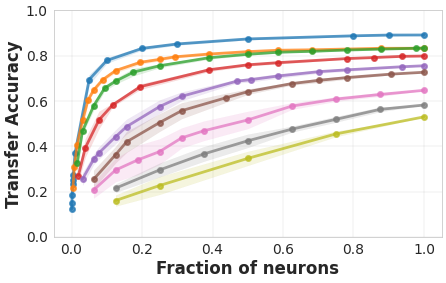

Uploading results in ['results/width_comparison/imagenet'] to contact.mpi-sws.org...
Uploading 12 files to server
copying results/width_comparison/imagenet/resnet50-resnet50_ff8-resnet50_ff16-resnet50_ff32-resnet50_ff64_cifar10_bs_256_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/width_comparison/imagenet/resnet50-resnet50_ff8-resnet50_ff16-resnet50_ff32-resnet50_ff64_cifar10_bs_256_nonrob.png
copying results/width_comparison/imagenet/resnet50-wide_resnet50_2-wide_resnet50_4_cifar10_bs_256_robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/width_comparison/imagenet/resnet50-wide_resnet50_2-wide_resnet50_4_cifar10_bs_256_robustl2eps3.png
copying results/width_comparison/imagenet/resnet50-resnet50_ff8-resnet50_ff16-resnet50_ff32-resnet50_ff64-resnet50_ff128-resnet50_ff256-resnet50_ff512-resnet50_ff1024_cifar10_bs_256_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/width_comparison/imagenet/resnet50-resnet50_ff8-res

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=100, bias=True))]), 'neuron_indices': tensor([874, 636, 761, 257]), 'in_features': 4, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=100, bias=True))]), 'neuron_indices': tensor([122, 739, 133,  11]), 'in_features': 4, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=100, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61]), 'in_features': 4, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=100, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002]), 'in_features': 4, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=4, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 708, 342,   9]), 'in_features': 4, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 708, 342,   9, 647, 767, 633, 291]), 'in_features': 8, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=100, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479]), 'in_features': 8, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=100, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18]), 'in_features': 8, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=100, bias=True))]), 'neuron_indices': tensor([122, 739, 133,  11, 853, 464, 457, 929]), 'in_features': 8, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=100, bias=True))]), 'neuron_indices': tensor([874, 636, 761, 257, 824, 970, 354, 432]), 'in_features': 8, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 708, 342,   9, 647, 767, 633, 291, 607, 306, 648, 514, 588, 660,
        257, 444]), 'in_features': 16, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=100, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18,  296,  258,  887,  422,
         719,  243,  912,  244]), 'in_features': 16, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=100, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479,  440,  300,  628,  847,
         779,  134,  439,  386]), 'in_features': 16, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=100, bias=True))]), 'neuron_indices': tensor([ 874,  636,  761,  257,  824,  970,  354,  432,  493,  373,  938,  758,
         981, 1014,  520,  589]), 'in_features': 16, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=100, bias=True))]), 'neuron_indices': tensor([122, 739, 133,  11, 853, 464, 457, 929,  10,  30, 386, 789, 715, 332,
        834, 687]), 'in_features': 16, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=100, bias=True))]), 'neuron_indices': tensor([122, 739, 133,  11, 853, 464, 457, 929,  10,  30, 386, 789, 715, 332,
        834, 687, 567, 151, 756, 681, 850, 125, 228, 641, 746, 158,  33, 541,
        199, 416, 869, 168, 262, 362, 858, 694, 650, 947, 105, 248, 736, 773,
        188, 513, 131, 915, 606, 521]), 'in_features': 48, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=100, bias=True))]), 'neuron_indices': tensor([ 874,  636,  761,  257,  824,  970,  354,  432,  493,  373,  938,  758,
         981, 1014,  520,  589,  631,  582,   26,  918,  152,  574,  439,  814,
         496,   66,  783,    8,  350,  634,  804,  659,   92,  896,  103,  795,
         857,  368,  340,  845,  509,  503,   52,  547,  198, 1016,  596,  800]), 'in_features': 48, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=100, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479,  440,  300,  628,  847,
         779,  134,  439,  386,  719,  401,  370,  544,   36,  798,  773,  691,
         475,  382,  688,  432,  583,  187,  893,  306,  970,  817,  820,  985,
         335,  223,  765,  889,  268,  848,  214,  537,  395,  337,  503,  107]), 'in_features': 48, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=100, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18,  296,  258,  887,  422,
         719,  243,  912,  244,  391,  790,  863,   68,  533,  485,  442,   17,
         708,   10,  313,  855,  723,  735,  222,  138,  701,  111,  644,  542,
         621,  567,  879,  488,  494,  765,  474,  774,  984,  659,  441,  237]), 'in_features': 48, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 708, 342,   9, 647, 767, 633, 291, 607, 306, 648, 514, 588, 660,
        257, 444, 694, 492, 878, 770, 758,  89, 126, 561, 747, 223, 786, 658,
        261, 403, 156, 783, 631, 353, 491, 818, 699, 640, 310, 354, 253, 220,
        649, 552,  47, 136, 646, 570]), 'in_features': 48, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=100, bias=True))]), 'neuron_indices': tensor([  37,  708,  342,    9,  647,  767,  633,  291,  607,  306,  648,  514,
         588,  660,  257,  444,  694,  492,  878,  770,  758,   89,  126,  561,
         747,  223,  786,  658,  261,  403,  156,  783,  631,  353,  491,  818,
         699,  640,  310,  354,  253,  220,  649,  552,   47,  136,  646,  570,
         673,  113,  112,  322,   92,  888,  855,  776,   95,  941,  955,  247,
         626,  428,  789,   36,  277,  886,  987,  408,  348,    2, 1019,  129,
         868,  210,  896,  983,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=100, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479,  440,  300,  628,  847,
         779,  134,  439,  386,  719,  401,  370,  544,   36,  798,  773,  691,
         475,  382,  688,  432,  583,  187,  893,  306,  970,  817,  820,  985,
         335,  223,  765,  889,  268,  848,  214,  537,  395,  337,  503,  107,
         816,  262,  500,  800,  170,  511,  292,  513,  591,  793,  263,  536,
         806,  502,  490,  264,  250,  669,  813,  454,  556,  651,  795,  828,
         504,  496,  521,  242,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=100, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18,  296,  258,  887,  422,
         719,  243,  912,  244,  391,  790,  863,   68,  533,  485,  442,   17,
         708,   10,  313,  855,  723,  735,  222,  138,  701,  111,  644,  542,
         621,  567,  879,  488,  494,  765,  474,  774,  984,  659,  441,  237,
         768,  479,  416,  538,  996,  898,  913,  300,  687,  514,  192,    5,
         525,  433,  435,  962,  369,  609, 1003,  919,  264,  236,  176,  393,
          28,   25,   33,   30, 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=100, bias=True))]), 'neuron_indices': tensor([ 122,  739,  133,   11,  853,  464,  457,  929,   10,   30,  386,  789,
         715,  332,  834,  687,  567,  151,  756,  681,  850,  125,  228,  641,
         746,  158,   33,  541,  199,  416,  869,  168,  262,  362,  858,  694,
         650,  947,  105,  248,  736,  773,  188,  513,  131,  915,  606,  521,
         538,  116,  623,  748,  306,  710,  500,  473,  922,  286,    7,   57,
        1023,  445,  671,  759,  977,  835,  601,  956,  433,  381,  294,  666,
         695,  984,  590,  220,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=100, bias=True))]), 'neuron_indices': tensor([ 874,  636,  761,  257,  824,  970,  354,  432,  493,  373,  938,  758,
         981, 1014,  520,  589,  631,  582,   26,  918,  152,  574,  439,  814,
         496,   66,  783,    8,  350,  634,  804,  659,   92,  896,  103,  795,
         857,  368,  340,  845,  509,  503,   52,  547,  198, 1016,  596,  800,
         273,  175,   43,  320,  701,  926,  458,  725,  973,  794,   45,  886,
         300,  453,  654,  775,  448,  823,  812,  168,  579,  944,  754,  714,
         559,  515,  311,  218,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=100, bias=True))]), 'neuron_indices': tensor([ 874,  636,  761,  257,  824,  970,  354,  432,  493,  373,  938,  758,
         981, 1014,  520,  589,  631,  582,   26,  918,  152,  574,  439,  814,
         496,   66,  783,    8,  350,  634,  804,  659,   92,  896,  103,  795,
         857,  368,  340,  845,  509,  503,   52,  547,  198, 1016,  596,  800,
         273,  175,   43,  320,  701,  926,  458,  725,  973,  794,   45,  886,
         300,  453,  654,  775,  448,  823,  812,  168,  579,  944,  754,  714,
         559,  515,  311,  218, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=100, bias=True))]), 'neuron_indices': tensor([ 122,  739,  133,   11,  853,  464,  457,  929,   10,   30,  386,  789,
         715,  332,  834,  687,  567,  151,  756,  681,  850,  125,  228,  641,
         746,  158,   33,  541,  199,  416,  869,  168,  262,  362,  858,  694,
         650,  947,  105,  248,  736,  773,  188,  513,  131,  915,  606,  521,
         538,  116,  623,  748,  306,  710,  500,  473,  922,  286,    7,   57,
        1023,  445,  671,  759,  977,  835,  601,  956,  433,  381,  294,  666,
         695,  984,  590,  220, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=100, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18,  296,  258,  887,  422,
         719,  243,  912,  244,  391,  790,  863,   68,  533,  485,  442,   17,
         708,   10,  313,  855,  723,  735,  222,  138,  701,  111,  644,  542,
         621,  567,  879,  488,  494,  765,  474,  774,  984,  659,  441,  237,
         768,  479,  416,  538,  996,  898,  913,  300,  687,  514,  192,    5,
         525,  433,  435,  962,  369,  609, 1003,  919,  264,  236,  176,  393,
          28,   25,   33,   30, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=100, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479,  440,  300,  628,  847,
         779,  134,  439,  386,  719,  401,  370,  544,   36,  798,  773,  691,
         475,  382,  688,  432,  583,  187,  893,  306,  970,  817,  820,  985,
         335,  223,  765,  889,  268,  848,  214,  537,  395,  337,  503,  107,
         816,  262,  500,  800,  170,  511,  292,  513,  591,  793,  263,  536,
         806,  502,  490,  264,  250,  669,  813,  454,  556,  651,  795,  828,
         504,  496,  521,  242, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=100, bias=True))]), 'neuron_indices': tensor([  37,  708,  342,    9,  647,  767,  633,  291,  607,  306,  648,  514,
         588,  660,  257,  444,  694,  492,  878,  770,  758,   89,  126,  561,
         747,  223,  786,  658,  261,  403,  156,  783,  631,  353,  491,  818,
         699,  640,  310,  354,  253,  220,  649,  552,   47,  136,  646,  570,
         673,  113,  112,  322,   92,  888,  855,  776,   95,  941,  955,  247,
         626,  428,  789,   36,  277,  886,  987,  408,  348,    2, 1019,  129,
         868,  210,  896,  983, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=300, out_features=100, bias=True))]), 'neuron_indices': tensor([ 122,  739,  133,   11,  853,  464,  457,  929,   10,   30,  386,  789,
         715,  332,  834,  687,  567,  151,  756,  681,  850,  125,  228,  641,
         746,  158,   33,  541,  199,  416,  869,  168,  262,  362,  858,  694,
         650,  947,  105,  248,  736,  773,  188,  513,  131,  915,  606,  521,
         538,  116,  623,  748,  306,  710,  500,  473,  922,  286,    7,   57,
        1023,  445,  671,  759,  977,  835,  601,  956,  433,  381,  294,  666,
         695,  984,  590,  220, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=300, out_features=100, bias=True))]), 'neuron_indices': tensor([ 874,  636,  761,  257,  824,  970,  354,  432,  493,  373,  938,  758,
         981, 1014,  520,  589,  631,  582,   26,  918,  152,  574,  439,  814,
         496,   66,  783,    8,  350,  634,  804,  659,   92,  896,  103,  795,
         857,  368,  340,  845,  509,  503,   52,  547,  198, 1016,  596,  800,
         273,  175,   43,  320,  701,  926,  458,  725,  973,  794,   45,  886,
         300,  453,  654,  775,  448,  823,  812,  168,  579,  944,  754,  714,
         559,  515,  311,  218, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=300, out_features=100, bias=True))]), 'neuron_indices': tensor([  37,  708,  342,    9,  647,  767,  633,  291,  607,  306,  648,  514,
         588,  660,  257,  444,  694,  492,  878,  770,  758,   89,  126,  561,
         747,  223,  786,  658,  261,  403,  156,  783,  631,  353,  491,  818,
         699,  640,  310,  354,  253,  220,  649,  552,   47,  136,  646,  570,
         673,  113,  112,  322,   92,  888,  855,  776,   95,  941,  955,  247,
         626,  428,  789,   36,  277,  886,  987,  408,  348,    2, 1019,  129,
         868,  210,  896,  983, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=300, out_features=100, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479,  440,  300,  628,  847,
         779,  134,  439,  386,  719,  401,  370,  544,   36,  798,  773,  691,
         475,  382,  688,  432,  583,  187,  893,  306,  970,  817,  820,  985,
         335,  223,  765,  889,  268,  848,  214,  537,  395,  337,  503,  107,
         816,  262,  500,  800,  170,  511,  292,  513,  591,  793,  263,  536,
         806,  502,  490,  264,  250,  669,  813,  454,  556,  651,  795,  828,
         504,  496,  521,  242, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=300, out_features=100, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18,  296,  258,  887,  422,
         719,  243,  912,  244,  391,  790,  863,   68,  533,  485,  442,   17,
         708,   10,  313,  855,  723,  735,  222,  138,  701,  111,  644,  542,
         621,  567,  879,  488,  494,  765,  474,  774,  984,  659,  441,  237,
         768,  479,  416,  538,  996,  898,  913,  300,  687,  514,  192,    5,
         525,  433,  435,  962,  369,  609, 1003,  919,  264,  236,  176,  393,
          28,   25,   33,   30, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=400, out_features=100, bias=True))]), 'neuron_indices': tensor([ 874,  636,  761,  257,  824,  970,  354,  432,  493,  373,  938,  758,
         981, 1014,  520,  589,  631,  582,   26,  918,  152,  574,  439,  814,
         496,   66,  783,    8,  350,  634,  804,  659,   92,  896,  103,  795,
         857,  368,  340,  845,  509,  503,   52,  547,  198, 1016,  596,  800,
         273,  175,   43,  320,  701,  926,  458,  725,  973,  794,   45,  886,
         300,  453,  654,  775,  448,  823,  812,  168,  579,  944,  754,  714,
         559,  515,  311,  218, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=400, out_features=100, bias=True))]), 'neuron_indices': tensor([ 122,  739,  133,   11,  853,  464,  457,  929,   10,   30,  386,  789,
         715,  332,  834,  687,  567,  151,  756,  681,  850,  125,  228,  641,
         746,  158,   33,  541,  199,  416,  869,  168,  262,  362,  858,  694,
         650,  947,  105,  248,  736,  773,  188,  513,  131,  915,  606,  521,
         538,  116,  623,  748,  306,  710,  500,  473,  922,  286,    7,   57,
        1023,  445,  671,  759,  977,  835,  601,  956,  433,  381,  294,  666,
         695,  984,  590,  220, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=400, out_features=100, bias=True))]), 'neuron_indices': tensor([  37,  708,  342,    9,  647,  767,  633,  291,  607,  306,  648,  514,
         588,  660,  257,  444,  694,  492,  878,  770,  758,   89,  126,  561,
         747,  223,  786,  658,  261,  403,  156,  783,  631,  353,  491,  818,
         699,  640,  310,  354,  253,  220,  649,  552,   47,  136,  646,  570,
         673,  113,  112,  322,   92,  888,  855,  776,   95,  941,  955,  247,
         626,  428,  789,   36,  277,  886,  987,  408,  348,    2, 1019,  129,
         868,  210,  896,  983, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=400, out_features=100, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18,  296,  258,  887,  422,
         719,  243,  912,  244,  391,  790,  863,   68,  533,  485,  442,   17,
         708,   10,  313,  855,  723,  735,  222,  138,  701,  111,  644,  542,
         621,  567,  879,  488,  494,  765,  474,  774,  984,  659,  441,  237,
         768,  479,  416,  538,  996,  898,  913,  300,  687,  514,  192,    5,
         525,  433,  435,  962,  369,  609, 1003,  919,  264,  236,  176,  393,
          28,   25,   33,   30, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=400, out_features=100, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479,  440,  300,  628,  847,
         779,  134,  439,  386,  719,  401,  370,  544,   36,  798,  773,  691,
         475,  382,  688,  432,  583,  187,  893,  306,  970,  817,  820,  985,
         335,  223,  765,  889,  268,  848,  214,  537,  395,  337,  503,  107,
         816,  262,  500,  800,  170,  511,  292,  513,  591,  793,  263,  536,
         806,  502,  490,  264,  250,  669,  813,  454,  556,  651,  795,  828,
         504,  496,  521,  242, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=600, out_features=100, bias=True))]), 'neuron_indices': tensor([  37,  708,  342,    9,  647,  767,  633,  291,  607,  306,  648,  514,
         588,  660,  257,  444,  694,  492,  878,  770,  758,   89,  126,  561,
         747,  223,  786,  658,  261,  403,  156,  783,  631,  353,  491,  818,
         699,  640,  310,  354,  253,  220,  649,  552,   47,  136,  646,  570,
         673,  113,  112,  322,   92,  888,  855,  776,   95,  941,  955,  247,
         626,  428,  789,   36,  277,  886,  987,  408,  348,    2, 1019,  129,
         868,  210,  896,  983, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=600, out_features=100, bias=True))]), 'neuron_indices': tensor([ 867,  451, 1005,   61,  150, 1023,  242,   18,  296,  258,  887,  422,
         719,  243,  912,  244,  391,  790,  863,   68,  533,  485,  442,   17,
         708,   10,  313,  855,  723,  735,  222,  138,  701,  111,  644,  542,
         621,  567,  879,  488,  494,  765,  474,  774,  984,  659,  441,  237,
         768,  479,  416,  538,  996,  898,  913,  300,  687,  514,  192,    5,
         525,  433,  435,  962,  369,  609, 1003,  919,  264,  236,  176,  393,
          28,   25,   33,   30, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=600, out_features=100, bias=True))]), 'neuron_indices': tensor([ 168,  361,  293, 1002,  522,   59, 1018,  479,  440,  300,  628,  847,
         779,  134,  439,  386,  719,  401,  370,  544,   36,  798,  773,  691,
         475,  382,  688,  432,  583,  187,  893,  306,  970,  817,  820,  985,
         335,  223,  765,  889,  268,  848,  214,  537,  395,  337,  503,  107,
         816,  262,  500,  800,  170,  511,  292,  513,  591,  793,  263,  536,
         806,  502,  490,  264,  250,  669,  813,  454,  556,  651,  795,  828,
         504,  496,  521,  242, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=600, out_features=100, bias=True))]), 'neuron_indices': tensor([ 874,  636,  761,  257,  824,  970,  354,  432,  493,  373,  938,  758,
         981, 1014,  520,  589,  631,  582,   26,  918,  152,  574,  439,  814,
         496,   66,  783,    8,  350,  634,  804,  659,   92,  896,  103,  795,
         857,  368,  340,  845,  509,  503,   52,  547,  198, 1016,  596,  800,
         273,  175,   43,  320,  701,  926,  458,  725,  973,  794,   45,  886,
         300,  453,  654,  775,  448,  823,  812,  168,  579,  944,  754,  714,
         559,  515,  311,  218, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=600, out_features=100, bias=True))]), 'neuron_indices': tensor([ 122,  739,  133,   11,  853,  464,  457,  929,   10,   30,  386,  789,
         715,  332,  834,  687,  567,  151,  756,  681,  850,  125,  228,  641,
         746,  158,   33,  541,  199,  416,  869,  168,  262,  362,  858,  694,
         650,  947,  105,  248,  736,  773,  188,  513,  131,  915,  606,  521,
         538,  116,  623,  748,  306,  710,  500,  473,  922,  286,    7,   57,
        1023,  445,  671,  759,  977,  835,  601,  956,  433,  381,  294,  666,
         695,  984,  590,  220, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=100, bias=True))]), 'neuron_indices': tensor([362, 165,  39, 391, 364,  80, 182, 397]), 'in_features': 8, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 158, 476, 186,  31, 123, 165, 223]), 'in_features': 8, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=8, out_features=100, bias=True))]), 'neuron_indices': tensor([168, 179, 433,  55, 190, 176, 148, 347]), 'in_features': 8, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=100, bias=True))]), 'neuron_indices': tensor([168, 179, 433,  55, 190, 176, 148, 347, 376, 125, 262, 165, 211, 123,
        299, 436]), 'in_features': 16, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 158, 476, 186,  31, 123, 165, 223, 295, 262, 214, 458,  28, 261,
         57, 258]), 'in_features': 16, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=16, out_features=100, bias=True))]), 'neuron_indices': tensor([362, 165,  39, 391, 364,  80, 182, 397,  69, 425, 174, 380, 337, 416,
        104, 255]), 'in_features': 16, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=100, bias=True))]), 'neuron_indices': tensor([362, 165,  39, 391, 364,  80, 182, 397,  69, 425, 174, 380, 337, 416,
        104, 255, 151, 221, 460,  48, 332,  31, 293, 375, 160, 155, 175, 371,
        494, 283, 214, 169, 156, 150, 261,  67, 189, 312, 328,  66, 277, 236,
        298, 145, 222, 309,  18, 295]), 'in_features': 48, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 158, 476, 186,  31, 123, 165, 223, 295, 262, 214, 458,  28, 261,
         57, 258,  86, 203, 450,  74, 494, 430, 488, 339, 251,  96, 312,  23,
        401, 384,  26, 356, 119,  76, 307, 257,  47, 378, 424, 390, 405, 460,
        177, 348, 359, 396, 382, 146]), 'in_features': 48, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=48, out_features=100, bias=True))]), 'neuron_indices': tensor([168, 179, 433,  55, 190, 176, 148, 347, 376, 125, 262, 165, 211, 123,
        299, 436, 143, 334, 146, 315,  60, 147,  65, 253, 483, 486, 336, 461,
        407, 162,  41, 485, 298, 337, 498, 205,   7, 233, 307, 140, 188, 465,
        500, 499, 391,  92, 259, 394]), 'in_features': 48, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=100, bias=True))]), 'neuron_indices': tensor([362, 165,  39, 391, 364,  80, 182, 397,  69, 425, 174, 380, 337, 416,
        104, 255, 151, 221, 460,  48, 332,  31, 293, 375, 160, 155, 175, 371,
        494, 283, 214, 169, 156, 150, 261,  67, 189, 312, 328,  66, 277, 236,
        298, 145, 222, 309,  18, 295, 241, 152, 355, 282, 141, 101,  98, 392,
        509, 280, 470, 274, 164, 498, 422, 113,  64, 483, 428, 450, 339,  71,
        432, 217, 431, 458,  21, 319, 297,  93, 479,  55, 485, 208, 510, 133,
        108, 171, 477, 213, 248, 393]), 'in_f

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 158, 476, 186,  31, 123, 165, 223, 295, 262, 214, 458,  28, 261,
         57, 258,  86, 203, 450,  74, 494, 430, 488, 339, 251,  96, 312,  23,
        401, 384,  26, 356, 119,  76, 307, 257,  47, 378, 424, 390, 405, 460,
        177, 348, 359, 396, 382, 146, 113, 407, 254, 300,  60, 140, 239, 174,
        391, 276, 199, 209, 246, 474, 371, 364, 213,  53, 311, 314, 204,   1,
        273, 505, 132,  24, 372, 388, 497,  16, 363, 286, 191, 148,  94, 167,
        143, 138, 351, 283, 226,  66]), 'in_f

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=90, out_features=100, bias=True))]), 'neuron_indices': tensor([168, 179, 433,  55, 190, 176, 148, 347, 376, 125, 262, 165, 211, 123,
        299, 436, 143, 334, 146, 315,  60, 147,  65, 253, 483, 486, 336, 461,
        407, 162,  41, 485, 298, 337, 498, 205,   7, 233, 307, 140, 188, 465,
        500, 499, 391,  92, 259, 394, 480,  40, 268, 258, 134,  83,  72, 332,
        255, 478, 397, 226,  18, 367, 224, 279, 442, 277, 387, 246, 280, 195,
         38, 126, 416, 459, 351, 296, 497, 330, 502,  27, 458, 174, 323, 477,
        251, 345, 166, 507, 408, 410]), 'in_f

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 158, 476, 186,  31, 123, 165, 223, 295, 262, 214, 458,  28, 261,
         57, 258,  86, 203, 450,  74, 494, 430, 488, 339, 251,  96, 312,  23,
        401, 384,  26, 356, 119,  76, 307, 257,  47, 378, 424, 390, 405, 460,
        177, 348, 359, 396, 382, 146, 113, 407, 254, 300,  60, 140, 239, 174,
        391, 276, 199, 209, 246, 474, 371, 364, 213,  53, 311, 314, 204,   1,
        273, 505, 132,  24, 372, 388, 497,  16, 363, 286, 191, 148,  94, 167,
        143, 138, 351, 283, 226,  66,  79, 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=100, bias=True))]), 'neuron_indices': tensor([168, 179, 433,  55, 190, 176, 148, 347, 376, 125, 262, 165, 211, 123,
        299, 436, 143, 334, 146, 315,  60, 147,  65, 253, 483, 486, 336, 461,
        407, 162,  41, 485, 298, 337, 498, 205,   7, 233, 307, 140, 188, 465,
        500, 499, 391,  92, 259, 394, 480,  40, 268, 258, 134,  83,  72, 332,
        255, 478, 397, 226,  18, 367, 224, 279, 442, 277, 387, 246, 280, 195,
         38, 126, 416, 459, 351, 296, 497, 330, 502,  27, 458, 174, 323, 477,
        251, 345, 166, 507, 408, 410, 160, 3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=200, out_features=100, bias=True))]), 'neuron_indices': tensor([362, 165,  39, 391, 364,  80, 182, 397,  69, 425, 174, 380, 337, 416,
        104, 255, 151, 221, 460,  48, 332,  31, 293, 375, 160, 155, 175, 371,
        494, 283, 214, 169, 156, 150, 261,  67, 189, 312, 328,  66, 277, 236,
        298, 145, 222, 309,  18, 295, 241, 152, 355, 282, 141, 101,  98, 392,
        509, 280, 470, 274, 164, 498, 422, 113,  64, 483, 428, 450, 339,  71,
        432, 217, 431, 458,  21, 319, 297,  93, 479,  55, 485, 208, 510, 133,
        108, 171, 477, 213, 248, 393, 478, 3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=350, out_features=100, bias=True))]), 'neuron_indices': tensor([362, 165,  39, 391, 364,  80, 182, 397,  69, 425, 174, 380, 337, 416,
        104, 255, 151, 221, 460,  48, 332,  31, 293, 375, 160, 155, 175, 371,
        494, 283, 214, 169, 156, 150, 261,  67, 189, 312, 328,  66, 277, 236,
        298, 145, 222, 309,  18, 295, 241, 152, 355, 282, 141, 101,  98, 392,
        509, 280, 470, 274, 164, 498, 422, 113,  64, 483, 428, 450, 339,  71,
        432, 217, 431, 458,  21, 319, 297,  93, 479,  55, 485, 208, 510, 133,
        108, 171, 477, 213, 248, 393, 478, 3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=350, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 158, 476, 186,  31, 123, 165, 223, 295, 262, 214, 458,  28, 261,
         57, 258,  86, 203, 450,  74, 494, 430, 488, 339, 251,  96, 312,  23,
        401, 384,  26, 356, 119,  76, 307, 257,  47, 378, 424, 390, 405, 460,
        177, 348, 359, 396, 382, 146, 113, 407, 254, 300,  60, 140, 239, 174,
        391, 276, 199, 209, 246, 474, 371, 364, 213,  53, 311, 314, 204,   1,
        273, 505, 132,  24, 372, 388, 497,  16, 363, 286, 191, 148,  94, 167,
        143, 138, 351, 283, 226,  66,  79, 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=350, out_features=100, bias=True))]), 'neuron_indices': tensor([168, 179, 433,  55, 190, 176, 148, 347, 376, 125, 262, 165, 211, 123,
        299, 436, 143, 334, 146, 315,  60, 147,  65, 253, 483, 486, 336, 461,
        407, 162,  41, 485, 298, 337, 498, 205,   7, 233, 307, 140, 188, 465,
        500, 499, 391,  92, 259, 394, 480,  40, 268, 258, 134,  83,  72, 332,
        255, 478, 397, 226,  18, 367, 224, 279, 442, 277, 387, 246, 280, 195,
         38, 126, 416, 459, 351, 296, 497, 330, 502,  27, 458, 174, 323, 477,
        251, 345, 166, 507, 408, 410, 160, 3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=500, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 158, 476, 186,  31, 123, 165, 223, 295, 262, 214, 458,  28, 261,
         57, 258,  86, 203, 450,  74, 494, 430, 488, 339, 251,  96, 312,  23,
        401, 384,  26, 356, 119,  76, 307, 257,  47, 378, 424, 390, 405, 460,
        177, 348, 359, 396, 382, 146, 113, 407, 254, 300,  60, 140, 239, 174,
        391, 276, 199, 209, 246, 474, 371, 364, 213,  53, 311, 314, 204,   1,
        273, 505, 132,  24, 372, 388, 497,  16, 363, 286, 191, 148,  94, 167,
        143, 138, 351, 283, 226,  66,  79, 1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=500, out_features=100, bias=True))]), 'neuron_indices': tensor([168, 179, 433,  55, 190, 176, 148, 347, 376, 125, 262, 165, 211, 123,
        299, 436, 143, 334, 146, 315,  60, 147,  65, 253, 483, 486, 336, 461,
        407, 162,  41, 485, 298, 337, 498, 205,   7, 233, 307, 140, 188, 465,
        500, 499, 391,  92, 259, 394, 480,  40, 268, 258, 134,  83,  72, 332,
        255, 478, 397, 226,  18, 367, 224, 279, 442, 277, 387, 246, 280, 195,
         38, 126, 416, 459, 351, 296, 497, 330, 502,  27, 458, 174, 323, 477,
        251, 345, 166, 507, 408, 410, 160, 3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=500, out_features=100, bias=True))]), 'neuron_indices': tensor([362, 165,  39, 391, 364,  80, 182, 397,  69, 425, 174, 380, 337, 416,
        104, 255, 151, 221, 460,  48, 332,  31, 293, 375, 160, 155, 175, 371,
        494, 283, 214, 169, 156, 150, 261,  67, 189, 312, 328,  66, 277, 236,
        298, 145, 222, 309,  18, 295, 241, 152, 355, 282, 141, 101,  98, 392,
        509, 280, 470, 274, 164, 498, 422, 113,  64, 483, 428, 450, 339,  71,
        432, 217, 431, 458,  21, 319, 297,  93, 479,  55, 485, 208, 510, 133,
        108, 171, 477, 213, 248, 393, 478, 3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=5, out_features=100, bias=True))]), 'neuron_indices': tensor([122,  70,  83, 170,  61]), 'in_features': 5, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=5, out_features=100, bias=True))]), 'neuron_indices': tensor([106, 204,  47, 105,  32]), 'in_features': 5, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=5, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 180,  88, 157, 119]), 'in_features': 5, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=5, out_features=100, bias=True))]), 'neuron_indices': tensor([168,  43, 227, 101, 246]), 'in_features': 5, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=5, out_features=100, bias=True))]), 'neuron_indices': tensor([ 99,  70,  55, 138,  66]), 'in_features': 5, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 180,  88, 157, 119, 177, 247, 162, 175, 161, 144, 255, 200,  66,
         63, 156, 118, 152, 120, 203]), 'in_features': 20, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=100, bias=True))]), 'neuron_indices': tensor([168,  43, 227, 101, 246, 215, 198, 143, 176, 241,  58, 147, 207,  32,
         11,  14,  95, 233,   8, 124]), 'in_features': 20, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=100, bias=True))]), 'neuron_indices': tensor([ 99,  70,  55, 138,  66,  19,  48,  54, 112, 228, 161, 171,  27, 210,
         56, 113, 199,  98, 129, 134]), 'in_features': 20, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=100, bias=True))]), 'neuron_indices': tensor([122,  70,  83, 170,  61,  89,  75, 155, 106, 242, 110, 177,  67,   9,
         98,  47, 183, 246,  64, 168]), 'in_features': 20, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=20, out_features=100, bias=True))]), 'neuron_indices': tensor([106, 204,  47, 105,  32, 181,  96, 255,  93,   8,  74, 157, 145, 168,
        232, 198, 151,  45,  38, 153]), 'in_features': 20, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=30, out_features=100, bias=True))]), 'neuron_indices': tensor([ 99,  70,  55, 138,  66,  19,  48,  54, 112, 228, 161, 171,  27, 210,
         56, 113, 199,  98, 129, 134, 133,  23, 136, 121,  28,  95,  57, 135,
         11, 187]), 'in_features': 30, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=30, out_features=100, bias=True))]), 'neuron_indices': tensor([168,  43, 227, 101, 246, 215, 198, 143, 176, 241,  58, 147, 207,  32,
         11,  14,  95, 233,   8, 124,  92,  10,   5, 183,  75, 232,  46, 163,
        235, 181]), 'in_features': 30, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=30, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 180,  88, 157, 119, 177, 247, 162, 175, 161, 144, 255, 200,  66,
         63, 156, 118, 152, 120, 203, 234, 199,  13, 151, 155, 142, 210,  82,
        237, 213]), 'in_features': 30, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=30, out_features=100, bias=True))]), 'neuron_indices': tensor([106, 204,  47, 105,  32, 181,  96, 255,  93,   8,  74, 157, 145, 168,
        232, 198, 151,  45,  38, 153, 164,  65,  91,  88, 152, 195, 193, 112,
         18, 230]), 'in_features': 30, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=30, out_features=100, bias=True))]), 'neuron_indices': tensor([122,  70,  83, 170,  61,  89,  75, 155, 106, 242, 110, 177,  67,   9,
         98,  47, 183, 246,  64, 168, 198, 251, 192, 150, 162, 233, 217,  74,
        187,  54]), 'in_features': 30, 'out_features': 100}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=128, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 180,  88, 157, 119, 177, 247, 162, 175, 161, 144, 255, 200,  66,
         63, 156, 118, 152, 120, 203, 234, 199,  13, 151, 155, 142, 210,  82,
        237, 213,  96,   5,  55,   7,  83, 229,  39,   0, 254,  99, 109, 220,
         36, 111,  91, 233,  64,  19, 129, 197, 182, 186, 140, 240,  93, 248,
        167,  27,  97, 150, 238,  12, 145, 214,  85, 232,  28, 207, 164,  43,
        173, 184, 108,  20,  26,  32, 141, 130,  24, 110, 239,  29,   1,  35,
         44,  21,  62, 252,  98, 216,  16,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=128, out_features=100, bias=True))]), 'neuron_indices': tensor([168,  43, 227, 101, 246, 215, 198, 143, 176, 241,  58, 147, 207,  32,
         11,  14,  95, 233,   8, 124,  92,  10,   5, 183,  75, 232,  46, 163,
        235, 181,  51, 162,  42, 211, 178, 177,  16, 121, 249,  77, 196, 173,
         96,   0,  55, 127,  39, 184,  80,  34, 102,  88, 206, 228,  68, 210,
         12,  17, 203,  89,  50, 223, 188,  24, 250, 137, 165, 118,  13, 186,
         87, 172, 240, 100,  97, 234, 169, 187, 104, 120, 154,  40,  76,  93,
        119,   2,  53, 189, 136, 199,  52,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=128, out_features=100, bias=True))]), 'neuron_indices': tensor([ 99,  70,  55, 138,  66,  19,  48,  54, 112, 228, 161, 171,  27, 210,
         56, 113, 199,  98, 129, 134, 133,  23, 136, 121,  28,  95,  57, 135,
         11, 187, 244, 180,  93, 220, 146,  40,  15, 165, 205, 235, 230, 124,
        254, 186,  30,  75, 255, 107, 240,  77, 190, 213, 156,  64, 159, 177,
        223,   9, 102, 118,  69, 238,   2, 212,  62,  78,  85,  16, 172, 245,
         34,  97,  39,  60, 153, 150, 145, 143,  53, 127, 158,  84, 175, 115,
         89, 131,  46, 248,  94, 243, 108, 2

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=128, out_features=100, bias=True))]), 'neuron_indices': tensor([122,  70,  83, 170,  61,  89,  75, 155, 106, 242, 110, 177,  67,   9,
         98,  47, 183, 246,  64, 168, 198, 251, 192, 150, 162, 233, 217,  74,
        187,  54, 153, 114,  38,  81, 132, 204,  62,  15,  93,  94,  40, 147,
         88, 216, 227, 101,  43,  49,  90, 113, 205, 151,  17, 169,   3, 191,
         82, 196,  55, 210,  12,   1, 175,  60, 209, 108, 133, 239,  77, 149,
         19,  91,  95, 105, 188,  35,  51, 238, 240, 107,  76, 152,  46, 203,
        255, 219, 208,  30, 129,  27, 111,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=128, out_features=100, bias=True))]), 'neuron_indices': tensor([106, 204,  47, 105,  32, 181,  96, 255,  93,   8,  74, 157, 145, 168,
        232, 198, 151,  45,  38, 153, 164,  65,  91,  88, 152, 195, 193, 112,
         18, 230, 108,  77, 188, 110,  49, 102,  89, 122, 244, 155, 125, 100,
        234,  27,  78, 247,  37,  87, 209,  67,  73,  46, 185,  95,  76,  68,
        117,  83,  29, 173, 236,   1, 208,  24,  64, 142, 154, 192, 199, 249,
        160,  51, 207, 242, 215, 212, 129, 126, 219,  19, 133, 240, 214, 118,
         61,  36, 165,   5,  34,  57,  20, 2

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=220, out_features=100, bias=True))]), 'neuron_indices': tensor([106, 204,  47, 105,  32, 181,  96, 255,  93,   8,  74, 157, 145, 168,
        232, 198, 151,  45,  38, 153, 164,  65,  91,  88, 152, 195, 193, 112,
         18, 230, 108,  77, 188, 110,  49, 102,  89, 122, 244, 155, 125, 100,
        234,  27,  78, 247,  37,  87, 209,  67,  73,  46, 185,  95,  76,  68,
        117,  83,  29, 173, 236,   1, 208,  24,  64, 142, 154, 192, 199, 249,
        160,  51, 207, 242, 215, 212, 129, 126, 219,  19, 133, 240, 214, 118,
         61,  36, 165,   5,  34,  57,  20, 2

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=220, out_features=100, bias=True))]), 'neuron_indices': tensor([122,  70,  83, 170,  61,  89,  75, 155, 106, 242, 110, 177,  67,   9,
         98,  47, 183, 246,  64, 168, 198, 251, 192, 150, 162, 233, 217,  74,
        187,  54, 153, 114,  38,  81, 132, 204,  62,  15,  93,  94,  40, 147,
         88, 216, 227, 101,  43,  49,  90, 113, 205, 151,  17, 169,   3, 191,
         82, 196,  55, 210,  12,   1, 175,  60, 209, 108, 133, 239,  77, 149,
         19,  91,  95, 105, 188,  35,  51, 238, 240, 107,  76, 152,  46, 203,
        255, 219, 208,  30, 129,  27, 111,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=220, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 180,  88, 157, 119, 177, 247, 162, 175, 161, 144, 255, 200,  66,
         63, 156, 118, 152, 120, 203, 234, 199,  13, 151, 155, 142, 210,  82,
        237, 213,  96,   5,  55,   7,  83, 229,  39,   0, 254,  99, 109, 220,
         36, 111,  91, 233,  64,  19, 129, 197, 182, 186, 140, 240,  93, 248,
        167,  27,  97, 150, 238,  12, 145, 214,  85, 232,  28, 207, 164,  43,
        173, 184, 108,  20,  26,  32, 141, 130,  24, 110, 239,  29,   1,  35,
         44,  21,  62, 252,  98, 216,  16,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=220, out_features=100, bias=True))]), 'neuron_indices': tensor([ 99,  70,  55, 138,  66,  19,  48,  54, 112, 228, 161, 171,  27, 210,
         56, 113, 199,  98, 129, 134, 133,  23, 136, 121,  28,  95,  57, 135,
         11, 187, 244, 180,  93, 220, 146,  40,  15, 165, 205, 235, 230, 124,
        254, 186,  30,  75, 255, 107, 240,  77, 190, 213, 156,  64, 159, 177,
        223,   9, 102, 118,  69, 238,   2, 212,  62,  78,  85,  16, 172, 245,
         34,  97,  39,  60, 153, 150, 145, 143,  53, 127, 158,  84, 175, 115,
         89, 131,  46, 248,  94, 243, 108, 2

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=220, out_features=100, bias=True))]), 'neuron_indices': tensor([168,  43, 227, 101, 246, 215, 198, 143, 176, 241,  58, 147, 207,  32,
         11,  14,  95, 233,   8, 124,  92,  10,   5, 183,  75, 232,  46, 163,
        235, 181,  51, 162,  42, 211, 178, 177,  16, 121, 249,  77, 196, 173,
         96,   0,  55, 127,  39, 184,  80,  34, 102,  88, 206, 228,  68, 210,
         12,  17, 203,  89,  50, 223, 188,  24, 250, 137, 165, 118,  13, 186,
         87, 172, 240, 100,  97, 234, 169, 187, 104, 120, 154,  40,  76,  93,
        119,   2,  53, 189, 136, 199,  52,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=240, out_features=100, bias=True))]), 'neuron_indices': tensor([ 37, 180,  88, 157, 119, 177, 247, 162, 175, 161, 144, 255, 200,  66,
         63, 156, 118, 152, 120, 203, 234, 199,  13, 151, 155, 142, 210,  82,
        237, 213,  96,   5,  55,   7,  83, 229,  39,   0, 254,  99, 109, 220,
         36, 111,  91, 233,  64,  19, 129, 197, 182, 186, 140, 240,  93, 248,
        167,  27,  97, 150, 238,  12, 145, 214,  85, 232,  28, 207, 164,  43,
        173, 184, 108,  20,  26,  32, 141, 130,  24, 110, 239,  29,   1,  35,
         44,  21,  62, 252,  98, 216,  16,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=240, out_features=100, bias=True))]), 'neuron_indices': tensor([ 99,  70,  55, 138,  66,  19,  48,  54, 112, 228, 161, 171,  27, 210,
         56, 113, 199,  98, 129, 134, 133,  23, 136, 121,  28,  95,  57, 135,
         11, 187, 244, 180,  93, 220, 146,  40,  15, 165, 205, 235, 230, 124,
        254, 186,  30,  75, 255, 107, 240,  77, 190, 213, 156,  64, 159, 177,
        223,   9, 102, 118,  69, 238,   2, 212,  62,  78,  85,  16, 172, 245,
         34,  97,  39,  60, 153, 150, 145, 143,  53, 127, 158,  84, 175, 115,
         89, 131,  46, 248,  94, 243, 108, 2

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=240, out_features=100, bias=True))]), 'neuron_indices': tensor([168,  43, 227, 101, 246, 215, 198, 143, 176, 241,  58, 147, 207,  32,
         11,  14,  95, 233,   8, 124,  92,  10,   5, 183,  75, 232,  46, 163,
        235, 181,  51, 162,  42, 211, 178, 177,  16, 121, 249,  77, 196, 173,
         96,   0,  55, 127,  39, 184,  80,  34, 102,  88, 206, 228,  68, 210,
         12,  17, 203,  89,  50, 223, 188,  24, 250, 137, 165, 118,  13, 186,
         87, 172, 240, 100,  97, 234, 169, 187, 104, 120, 154,  40,  76,  93,
        119,   2,  53, 189, 136, 199,  52,  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.
Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('linear', Linear(in_features=240, out_features=100, bias=True))]), 'neuron_indices': tensor([106, 204,  47, 105,  32, 181,  96, 255,  93,   8,  74, 157, 145, 168,
        232, 198, 151,  45,  38, 153, 164,  65,  91,  88, 152, 195, 193, 112,
         18, 230, 108,  77, 188, 110,  49, 102,  89, 122, 244, 155, 125, 100,
        234,  27,  78, 247,  37,  87, 209,  67,  73,  46, 185,  95,  76,  68,
        117,  83,  29, 173, 236,   1, 208,  24,  64, 142, 154, 192, 199, 249,
        160,  51, 207, 242, 215, 212, 129, 126, 219,  19, 133, 240, 214, 118,
         61,  36, 165,   5,  34,  57,  20, 2

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting: 0it [00:00, ?it/s]

In [ ]:
SOURCE_DATASET = 'imagenet'
MODELS = ['resnet50', 'resnet50_ff1024', 'resnet50_ff512', 'resnet50_ff256', 'resnet50_ff128',
          'resnet50_ff64', 'resnet50_ff32', 'resnet50_ff16', 'resnet50_ff8']
FRACTIONS_OR_NUMBERS = [
    None,
    [4,8,16,32,48,64,90,128,200,256,300,400,512,600,700,900,1024],
    [8,16,32,48,64,90,128,200,256,300,350,400,450,500,512],    
    [5,10,20,30,50,100,128,150,200,220,240,256],
    [4,8,10,16,20,32,40,60,65,75,90,100,120,128],    
    [4,8,10,16,20,28,32,40,45,50,58,64],
    [2,4,6,8,10,12,16,20,24,28,32],
    [2,4,6,8,10,12,14,16],
    [1,2,4,6,8]
]
APPEND = 'nonrob'

FT_DATASET = 'cifar10'
results(MODELS, SOURCE_DATASET, FT_DATASET, APPEND, FRACTIONS_OR_NUMBERS)

FT_DATASET = 'cifar100'
results(MODELS, SOURCE_DATASET, FT_DATASET, APPEND, FRACTIONS_OR_NUMBERS)

FT_DATASET = 'flowers'
results(MODELS, SOURCE_DATASET, FT_DATASET, APPEND, FRACTIONS_OR_NUMBERS)

FT_DATASET = 'oxford-iiit-pets'
results(MODELS, SOURCE_DATASET, FT_DATASET, APPEND, FRACTIONS_OR_NUMBERS)